In [ ]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
#we start by exploring our datasets.
DATA_DIR = './data'

['multitask_dataset_beat',
 'fma_genre_spectrograms',
 'fma_genre_spectrograms_beat',
 'multitask_dataset']

In [ ]:
#Step1a
import random
random.seed(13)

path = os.path.join(DATA_DIR, "fma_genre_spectrograms/train_labels.txt")
train_labels = pd.read_csv(path, header = 0, sep = '\t')

#randomly generate 2 indices so we can choose 2 training data.
index_1, index_2 = random.sample(range(0, train_labels.shape[0] - 1), 2)

#print their labels, aka ID and Genre. We replace the '.gz' so that we can use the files from the train file (we will check this out later)
ID_1 = train_labels.iloc[index_1][0].replace(".gz", "") 
Genre_1 = train_labels.iloc[index_1][1]
ID_2 = train_labels.iloc[index_2][0].replace(".gz", "")
Genre_2 = train_labels.iloc[index_2][1]

print(Genre_1, Genre_2)

Indie-Rock International


In [ ]:
#Step1b
#the path for the train data:
train_path = os.path.join(DATA_DIR, "fma_genre_spectrograms/train/")

#So we can get the actual random files we chose from the previous step:
extra_1 = ID_1
extra_2 = ID_2

#the full path to our train data:
spec_1 = np.load(train_path + extra_1)
spec_2 = np.load(train_path + extra_2)

#To decompose into the mel spectrogram and chromagram:
mel_1, chroma_1 = spec_1[:128], spec_1[128:]
mel_2, chroma_2 = spec_2[:128], spec_2[128:]

print(mel_1.shape)
print(mel_2.shape)


(128, 1293)
(128, 1291)


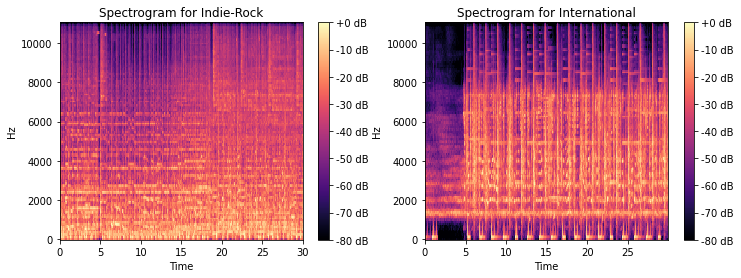

In [6]:
#Step1c
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12,4))

for ax, mel, title in zip([ax1, ax2],[mel_1, mel_2],['Spectrogram for Indie-Rock', 'Spectrogram for International']):
 img = librosa.display.specshow(mel, x_axis = 'time', y_axis = 'linear', ax = ax)
 ax.set(title = title)
 fig.colorbar(img, ax = ax, format = "%+2.f dB")
    

(128, 38)
(128, 39)


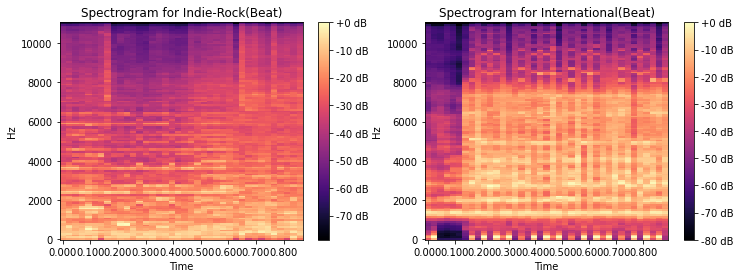

In [ ]:
#Step 2b (step 2a already done above)

train_path = os.path.join(DATA_DIR, "fma_genre_spectrograms/train/")

#the full path to our train data:
spec_1_beat = np.load(beat_path + extra_1)
spec_2_beat = np.load(beat_path + extra_2)

#To decompose into the mel spectrogram and chromagram:
mel_1_beat, chroma_1_beat = spec_1_beat[:128], spec_1_beat[128:]
mel_2_beat, chroma_2_beat = spec_2_beat[:128], spec_2_beat[128:]

print(mel_1_beat.shape)
print(mel_2_beat.shape)

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12,4))

for ax, mel, title in zip([ax1, ax2],[mel_1_beat, mel_2_beat],['Spectrogram for Indie-Rock(Beat)', 'Spectrogram for International(Beat)']):
 img = librosa.display.specshow(mel, x_axis = 'time', y_axis = 'linear', ax = ax)
 ax.set(title = title)
 fig.colorbar(img, ax = ax, format = "%+2.f dB")
    

(12, 1293) (12, 1291)
(12, 38) (12, 39)


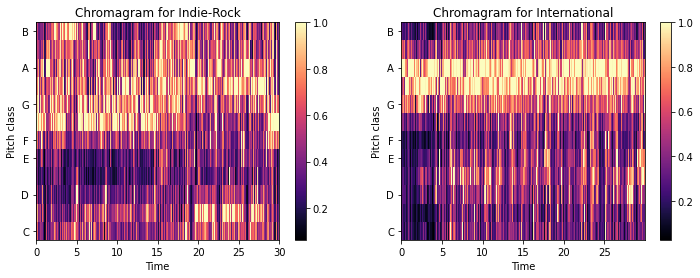

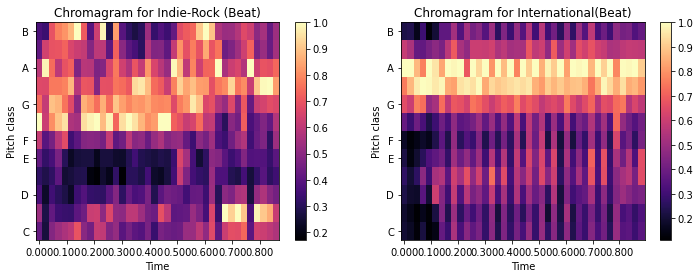

In [8]:
#Step 3
print(chroma_1.shape, chroma_2.shape)
print(chroma_1_beat.shape, chroma_2_beat.shape)

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12,4))

for ax, chroma, title in zip([ax1, ax2],[chroma_1, chroma_2],['Chromagram for Indie-Rock', 'Chromagram for International']):    
 img = librosa.display.specshow(chroma, y_axis = 'chroma', x_axis = 'time', ax = ax)
 ax.set(title = title)
 fig.colorbar(img, ax = ax)


fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12,4))

for ax, chroma, title in zip([ax1, ax2],[chroma_1_beat, chroma_2_beat],['Chromagram for Indie-Rock (Beat)', 'Chromagram for International(Beat)']):    
 img = librosa.display.specshow(chroma, y_axis = 'chroma', x_axis = 'time', ax = ax)
 ax.set(title = title)
 fig.colorbar(img, ax = ax)

In [9]:
#Step 4
import copy
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader

#The functions and clsses shown below where forked from 'https://www.kaggle.com/code/panagiotiskininis/lab3-data-loading-tutorial/edit'. 
# Combine similar classes and remove underrepresented classes
CLASS_MAPPING = {
    'Rock': 'Rock',
    'Psych-Rock': 'Rock',
    'Indie-Rock': None,
    'Post-Rock': 'Rock',
    'Psych-Folk': 'Folk',
    'Folk': 'Folk',
    'Metal': 'Metal',
    'Punk': 'Metal',
    'Post-Punk': None,
    'Trip-Hop': 'Trip-Hop',
    'Pop': 'Pop',
    'Electronic': 'Electronic',
    'Hip-Hop': 'Hip-Hop',
    'Classical': 'Classical',
    'Blues': 'Blues',
    'Chiptune': 'Electronic',
    'Jazz': 'Jazz',
    'Soundtrack': None,
    'International': None,
    'Old-Time': None
}


# Helper function to read fused, mel, and chromagram depending on the variable 'spectype'.
    
def torch_train_val_split(dataset, batch_train, batch_eval, val_size=.2, shuffle=True, seed = 42):
    
    # Creating data indices for training and validation splits:
    # We have to enter a seed for debugging reasons.
    
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
        
    train_indices = indices[val_split:]
    val_indices = indices[:val_split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset, batch_size = batch_train, sampler = train_sampler)
    val_loader = DataLoader(dataset, batch_size = batch_eval, sampler = val_sampler)
    
    return train_loader, val_loader

def read_spectrogram(spectrogram_file, spectype = 'both'):
    
    # with open(spectrogram_file, "r") as f:
    spectrograms = np.load(spectrogram_file)
    
    # spectrograms contain a fused mel spectrogram and chromagram
    if spectype == 'both':
        
        return spectrograms.T
    
    elif spectype == 'mel':
        
        return spectrograms[:128].T
    
    elif spectype == 'chroma':
        
        return spectrograms[128:].T

class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            
            return super(LabelTransformer, self).inverse_transform(y)
        
        except:
            
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            
            return super(LabelTransformer, self).transform(y)
        
        except:
            
            return super(LabelTransformer, self).transform([y])
        
class PaddingTransform(object):
    # We note here that padding_value = 0 is never utilized, since the padding
    # is performed by default using zeros, since np.zeros is called.
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value

    def __call__(self, s):
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[: self.max_length]

        if len(s) < self.max_length:
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1

class SpectrogramDataset(Dataset):
    def __init__(
        self, path, class_mapping = None, train = True, max_length = -1, spectype = 'both'
    ):
        
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        
        self.spectype = spectype
        
        self.index = os.path.join(path, f"{t}_labels.txt")
        self.files, labels = self.get_files_labels(self.index, class_mapping)
        self.feats = [read_spectrogram(os.path.join(p, f), spectype=self.spectype) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        
        self.label_transformer = LabelTransformer()
        
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(self.label_transformer.fit_transform(labels)).astype("int64")
        
    def get_files_labels(self, txt, class_mapping):
        
        with open(txt, "r") as fd:
            
            lines = [l.rstrip().split('\t') for l in fd.readlines()[1:]]
            
        files, labels = [], []
        
        for l in lines:
            
            label = l[1]
            
            if class_mapping:
                
                label = class_mapping[l[1]]
                
            if not label:
                
                continue
                
            # Kaggle automatically unzips the npy.gz format so this hack is needed
            _id = l[0].split('.')[0]
            npy_file = '{}.fused.full.npy'.format(_id)
            files.append(npy_file)
            labels.append(label)
            
        return files, labels

    def __getitem__(self, item):
        # TODO: Inspect output and comment on how the output is formatted
        length = min(self.lengths[item], self.max_length)
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item], length

    def __len__(self):
        return len(self.labels)

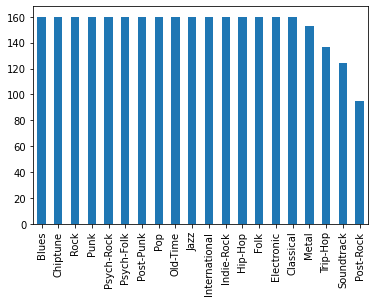

In [10]:
#the before bar-plot (Step 4c)

temp = train_labels['Genre'].value_counts()
temp.plot(kind = 'bar')
plt.show()

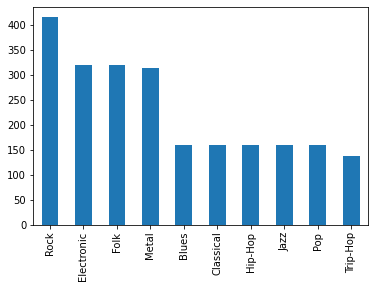

In [ ]:
train_path = os.path.join(DATA_DIR, 'fma_genre_spectrograms/')
train_dataset = SpectrogramDataset(train_path, class_mapping = CLASS_MAPPING)

genres_trans = []

for item in train_dataset:
    # Perform the inverse transform to get the non-integer type class
    # assigned to each item. The inverse transform gives us back an array-type object like: array(['Blues'], dtype='<U10'). 
    # We only need the proper label. Therefore, we only keep the [0] part of it. 
    genres_trans.append(train_dataset.label_transformer.inverse(item[1])[0])

train_labels_trans = pd.DataFrame({'Transformed Genres': genres_trans})

#the after bar-plot (Step 4c)
train_labels_trans['Transformed Genres'].value_counts().plot(kind='bar')
plt.show()


In [12]:
#forked from https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pth', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'Validation loss increase spotted. Early stopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [13]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PadPackedSequence(nn.Module):
    def __init__(self):
        
        """Wrap sequence padding in nn.Module
        Args:
            batch_first (bool, optional): Use batch first representation. Defaults to True.
        """
        
        super(PadPackedSequence, self).__init__()
        
        self.batch_first = True
        self.max_length = None

    def forward(self, x):
        """Convert packed sequence to padded sequence
        Args:
            x (torch.nn.utils.rnn.PackedSequence): Packed sequence
        Returns:
            torch.Tensor: Padded sequence
        """
        out, lengths = pad_packed_sequence(
            x, batch_first = self.batch_first, total_length = self.max_length  
        )
        lengths = lengths.to(out.device)
        return out, lengths  # type: ignore


class PackSequence(nn.Module):
    def __init__(self):
        """Wrap sequence packing in nn.Module
        Args:
            batch_first (bool, optional): Use batch first representation. Defaults to True.
        """
        super(PackSequence, self).__init__()
        self.batch_first = True

    def forward(self, x, lengths):
        """Pack a padded sequence and sort lengths
        Args:
            x (torch.Tensor): Padded tensor
            lengths (torch.Tensor): Original lengths befor padding
        Returns:
            Tuple[torch.nn.utils.rnn.PackedSequence, torch.Tensor]: (packed sequence, sorted lengths)
        """
        lengths = lengths.to("cpu")
        out = pack_padded_sequence(
            x, lengths, batch_first=self.batch_first, enforce_sorted=False
        )

        return out

#The LSTMBackbone class has three main components: the LSTM layer, a dropout layer, 
#and a linear layer. The LSTM layer is responsible for processing the input data and 
#maintaining an internal state that captures the dependencies between the input data at 
#different points in time. The dropout layer is used to prevent overfitting by randomly 
#setting some of the activations of the LSTM layer to zero during training. The linear 
#layer is used to transform the output of the LSTM layer into the final prediction.

class LSTMBackbone(nn.Module):
    def __init__(self,input_dim,output_dim,rnn_size=128,num_layers=1,bidirectional=False,dropout=0.1,):
        
        super(LSTMBackbone, self).__init__()

        self.batch_first = True
        self.bidirectional = bidirectional
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size

        self.input_dim = input_dim
        self.rnn_size = rnn_size
        self.num_layers = num_layers
        self.hidden_size = rnn_size
        self.pack = PackSequence()
        self.unpack = PadPackedSequence()
        self.batch_first = True
        
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=rnn_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=self.bidirectional,
            dropout=dropout,
        )
        
        self.drop = nn.Dropout(dropout)
        self.linear = nn.Linear(self.feature_size, output_dim)
        
#The forward method of the LSTMBackbone class takes as input a batch of sequences, x, 
#and the original lengths of the sequences in the batch, lengths. 
#The sequences are first packed using the pack method, which removes the padding 
#from the sequences and returns a packed sequence object. The packed sequence 
#is then passed through the LSTM layer, which processes the sequences and returns output, 
#a packed sequence object, and a tuple of the final hidden and cell states. 
#The output packed sequence is then unpacked using the unpack method, which adds the padding
#back to the sequences and returns the unpacked sequence and the original lengths of the sequences. 
#The output of the LSTM layer is then passed through the dropout layer and the linear layer,
#which produces the final prediction.

    def forward(self, x, lengths):
        """LSTM forward
        Args:
            x (torch.Tensor):
                [B, S, F] Batch size x sequence length x feature size
                padded inputs
            lengths (torch.tensor):
                [B] Original lengths of each padded sequence in the batch
        Returns:
            torch.Tensor:
                [B, H] Batch size x hidden size lstm last timestep outputs
                2 x hidden_size if bidirectional
        """
        packed = self.pack(x, lengths)
        output, _ = self.lstm(packed)
        output, lengths = self.unpack(output)
        output = self.drop(output)

        rnn_all_outputs, last_timestep = self._final_output(output, lengths)
        
        # Use the last_timestep for classification / regression
        last_timestep = self.linear(last_timestep)
        # Alternatively rnn_all_outputs can be used with an attention mechanism
        
        return last_timestep
    
#The _merge_bi method is used to merge the forward and backward states of the LSTM layer 
#when the LSTM network is bidirectional.

    def _merge_bi(self, forward, backward):
        """Merge forward and backward states
        Args:
            forward (torch.Tensor): [B, L, H] Forward states
            backward (torch.Tensor): [B, L, H] Backward states
        Returns:
            torch.Tensor: [B, L, 2*H] Merged forward and backward states
        """
        return torch.cat((forward, backward), dim=-1)
    
#The _final_output method is used to extract the final output of the LSTM layer, 
#which is used for classification or regression.

    def _final_output(self, out, lengths):
        """Create RNN ouputs
        Collect last hidden state for forward and backward states
        Code adapted from https://stackoverflow.com/a/50950188
        Args:
            out (torch.Tensor): [B, L, num_directions * H] RNN outputs
            lengths (torch.Tensor): [B] Original sequence lengths
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: (
                merged forward and backward states [B, L, H] or [B, L, 2*H],
                merged last forward and backward state [B, H] or [B, 2*H]
            )
        """

        if not self.bidirectional:
            return out, self._select_last_unpadded(out, lengths)

        forward, backward = (out[..., : self.hidden_size], out[..., self.hidden_size :])
        # Last backward corresponds to first token
        last_backward_out = backward[:, 0, :] if self.batch_first else backward[0, ...]
        # Last forward for real length or seq (unpadded tokens)
        last_forward_out = self._select_last_unpadded(forward, lengths)
        out = self._merge_bi(forward, backward) if self._merge_bi != "cat" else out

        return out, self._merge_bi(last_forward_out, last_backward_out)
    
#The _select_last_unpadded method is used to select the last output of the LSTM 
#layer for each sequence in the batch, excluding the padding.

    def _select_last_unpadded(self, out, lengths):
        """Get the last timestep before padding starts
        Args:
            out (torch.Tensor): [B, L, H] Fprward states
            lengths (torch.Tensor): [B] Original sequence lengths
        Returns:
            torch.Tensor: [B, H] Features for last sequence timestep
        """
        gather_dim = 1  # Batch first
        gather_idx = ((lengths - 1).unsqueeze(1).expand((-1, self.hidden_size)).unsqueeze(gather_dim))  #-1 to convert to indices, (B) -> (B, 1), (B, 1) -> (B, H), (B, 1, H) if batch_first else (1, B, H)
            
        # Last forward for real length or seq (unpadded tokens)
        last_out = out.gather(gather_dim, gather_idx).squeeze(gather_dim)

        return last_out
    
def load_backbone_from_checkpoint(model, checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))

In [108]:
def save_checkpoint(model):
    model.load_state_dict(torch.load(checkpoint_path))


def training_loop(model, train_dataloader, optimizer, device="cuda"):
    
    model.train() # Sets model to train mode
    batch_losses = []
    
    for batch in train_dataloader:
        
        x_batch, y_batch, x_len = batch
        
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        
        # forward pass
        if isinstance(model, LSTMBackbone):
            
            yhat = model(x_batch, x_len)
            
        elif isinstance(model, CNNBackbone):
            
            yhat = model(x_batch) # No unpacking occurs in CNNs
        
        
        #forward 
        
        if isinstance(loss_function, nn.CrossEntropyLoss):
            
            loss = loss_function(yhat, y_batch)
            
        elif isinstance(loss_function, MultiTaskLoss):
            
            new_yhat = list((torch.flatten(yhat[0]).to(device),
                             torch.flatten(yhat[1]).to(device),
                             torch.flatten(yhat[2]).to(device)))
            new_ybatch = list((y_batch[:,0].to(device), y_batch[:,1].to(device),
                               y_batch[:,2].to(device)))
            loss = loss_function(new_yhat, new_ybatch)
        else: # Workaround for non-multi-task regression
            yhat = torch.flatten(yhat)
            loss = loss_function(yhat, y_batch)
        
        #loss = loss_function(yhat, y_batch.unsqueeze(1))
        loss.backward()
        
        #set the previous gradient to zero for the next step
        optimizer.step()
        
        batch_losses.append(loss.data.item())
        
    train_loss = np.mean(batch_losses)

    return train_loss  # Return train_loss and anything else you need


def validation_loop(model, val_dataloader, device="cuda"):
    
    model.eval() # Sets model to val mode
    
    batch_losses = []
    
    for batch in val_dataloader:
        
        x_batch, y_batch, x_len = batch
        
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        #forward 
        if isinstance(model, LSTMBackbone):
            
            yhat = model(x_batch, x_len)
            
        elif isinstance(model, CNNBackbone):
            
            yhat = model(x_batch)  #predictions on x
        
        if isinstance(loss_function, nn.CrossEntropyLoss):
            
            loss = loss_function(yhat, y_batch)
            
        elif isinstance(loss_function, MultiTaskLoss):
            
            new_yhat = list((torch.flatten(yhat[0]).to(device),
                             torch.flatten(yhat[1]).to(device),
                             torch.flatten(yhat[2]).to(device)))
            new_ybatch = list((y_batch[:,0].to(device), y_batch[:,1].to(device),
                               y_batch[:,2].to(device)))
            loss = loss_function(new_yhat, new_ybatch)
        else: # Workaround for non-multi-task regression
            yhat = torch.flatten(yhat)
            loss = loss_function(yhat, y_batch)
        #loss = loss_function(yhat, y_batch.unsqueeze(1))
        
        batch_losses.append(loss.data.item())
        
    val_loss = np.mean(batch_losses)

    return val_loss  # Return val_loss and anything else you need


def overfit_with_a_couple_of_batches(model, train_dataloader):
    
    num_batches = 1 # a few batches only
    batches = []
    n_epochs = 2500  # An absurd number of epochs

    for i in range(num_batches):
        batch = next(iter(train_dataloader))
        batches.append(batch)
        
    train_losses = []
    
    for n_epochs in range(n_epochs):
        
        model.train()
        batch_losses = []
        
        for batch in batches:
            
            x_batch, y_batch, x_len = batch
                
            # Move to device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Clear the previous gradients first
            optimizer.zero_grad()

            # forward pass
            if isinstance(model, LSTMBackbone):
                
                yhat = model(x_batch, x_len)
            
            elif isinstance(model, CNNBackbone):
                
                yhat = model(x_batch) 
                
            # loss calculation
            loss = loss_function(yhat, y_batch)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            batch_losses.append(loss.data.item())
            
        train_loss = np.mean(batch_losses)
        train_losses.append(train_loss)

    plt.plot(train_losses, label="Training loss", color='r')
    plt.ylabel('Mean Loss')
    plt.xlabel('Epochs')
    plt.title(f"Loss graph during the process of training.")
    plt.show()

def train(model, train_dataloader, val_dataloader, optimizer, epochs, device="cuda", overfit_batch=False, patience = -1, temp=100):
    
    train_losses = []
    val_losses = []
    
    if isinstance(model, LSTMBackbone):
        net = 'LSTM'
    elif isinstance(model, CNNBackbone):
        net = 'CNN'
        
    if overfit_batch:
        
        print(f"Initiating overfitting training.")
    
        overfit_with_a_couple_of_batches(model, train_dataloader)
    
    else:
        print(f"Initiating training.")
        model_path = f'{net}.pt'
        
        if patience != -1:
            
            early_stopping = EarlyStopping(patience=patience, verbose=False, path='checkpoint.pth')
        
        for epoch in range(epochs):
            # Training loop
            
            train_loss = training_loop(model, train_dataloader, optimizer, device)    
            train_losses.append(train_loss)
            
            # Validation loop
            with torch.no_grad():
                
                val_loss = validation_loop(model, val_dataloader, device)
                val_losses.append(val_loss)
                
            if patience != -1:
                early_stopping(val_loss, model)
                
                if early_stopping.early_stop:
                    print("Early stop. Going back to the last checkpoint.")
                    break
            
            if epoch % temp == 0:        
                print(f"[{epoch}/{epochs}] Training loss: {train_loss:.4f}\t Validation loss: {val_loss:.4f}.")

        if patience != -1 and early_stopping.early_stop == True:
            load_backbone_from_checkpoint(model,'checkpoint.pth')
        
        torch.save(model.state_dict(), model_path)

    print("training finished.")
    
    return train_losses, val_losses
    
def evaluate(model, test_dataloader, device="cuda"):
    model.eval()
    predictions = [] # predicted values
    labels = [] # ground truth
    with torch.no_grad():
        
        for batch in test_dataloader:
            
            x_batch, y_batch, x_len = batch
                
            # Move to device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            if isinstance(model, LSTMBackbone):
                
                yhat = model(x_batch, x_len)
                
            elif isinstance(model, CNNBackbone):
                
                yhat = model(x_batch)
            
            # Calculate the index of the maximum argument
            yhat_idx = torch.argmax(yhat, dim=1)
            
            predictions.append(yhat_idx.cpu().numpy())
            labels.append(y_batch.cpu().numpy())
    
    return predictions, labels  # Return the model predictions


In [15]:
#function to plot train and val losses on the same plot.
def plot_losses(train_losses,val_losses,title):
    
    plt.plot(train_losses, label="Training loss", color='r')
    plt.plot(val_losses, label="Validation loss", color='b')
    plt.legend(loc='best')
    plt.ylabel('Mean Loss')
    plt.xlabel('Epochs')
    plt.title(title)
    plt.show()

In [16]:
'''
batch_size = 32
mel_specs_for_overfitting = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/', class_mapping = CLASS_MAPPING, spectype='mel')
    
train_loader_mel_overfit, val_loader_mel_overfit = torch_train_val_split(mel_specs_for_overfitting, batch_size, batch_size, val_size=1/3)
'''

"\nbatch_size = 32\nmel_specs_for_overfitting = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/', class_mapping = CLASS_MAPPING, spectype='mel')\n    \ntrain_loader_mel_overfit, val_loader_mel_overfit = torch_train_val_split(mel_specs_for_overfitting, batch_size, batch_size, val_size=1/3)\n"

In [17]:
'''
# LSTM overfitting
num_mel = 128 #input_dimensions, since melograms are :128
output_dim = 10 # number of genres after filtering them

rnn_size = 32 #when we ran it for 64, it took a lot of time (like, too much) to show us the results
num_layers = 1
dropout = 0.0 #no dropout needed for overfitting due to the absurd amount of epochs
learning_rate = 0.001 #random
weight_decay = 0.0 #no regularization needed for overfitting due to the absurd amount of epochs
patience = -1 #we dont want it to early-stop
overfit_batch = True #self - explanatory
bidirectional = True #self - explanatory

epochs = 500

model = LSTMBackbone(input_dim = num_mel, output_dim=output_dim, rnn_size = rnn_size, num_layers = num_layers, bidirectional = bidirectional, dropout = dropout)
model.double()
model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #, weight_decay = weight_decay

# Overfit the model
train_losses_overfit, val_losses_overfit = train(model, train_loader_mel_overfit, val_loader_mel_overfit, optimizer, epochs, device=device, overfit_batch=overfit_batch, patience=patience)
'''

'\n# LSTM overfitting\nnum_mel = 128 #input_dimensions, since melograms are :128\noutput_dim = 10 # number of genres after filtering them\n\nrnn_size = 32 #when we ran it for 64, it took a lot of time (like, too much) to show us the results\nnum_layers = 1\ndropout = 0.0 #no dropout needed for overfitting due to the absurd amount of epochs\nlearning_rate = 0.001 #random\nweight_decay = 0.0 #no regularization needed for overfitting due to the absurd amount of epochs\npatience = -1 #we dont want it to early-stop\noverfit_batch = True #self - explanatory\nbidirectional = True #self - explanatory\n\nepochs = 500\n\nmodel = LSTMBackbone(input_dim = num_mel, output_dim=output_dim, rnn_size = rnn_size, num_layers = num_layers, bidirectional = bidirectional, dropout = dropout)\nmodel.double()\nmodel.to(device)\nloss_function = nn.CrossEntropyLoss()\noptimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #, weight_decay = weight_decay\n\n# Overfit the model\ntrain_losses_overfit, 

In [18]:
'''
#necessary cleaning so that our notebook won't be blowed up due to lengthy data
import gc

del train_losses_overfit
del val_losses_overfit
gc.collect()
'''
from sklearn.metrics import f1_score, accuracy_score, recall_score, classification_report


In [19]:
'''
#training based on mel spectrogram data
batch_size = 32

mel_data = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', class_mapping=CLASS_MAPPING, spectype='mel')
train_loader_mel, val_loader_mel = torch_train_val_split(mel_data, batch_size ,batch_size, val_size=1/3)

mel_data_test = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', train=False, class_mapping=CLASS_MAPPING, spectype='mel')
test_loader_mel = DataLoader(mel_data_test, batch_size = batch_size)

num_mel = 128 #input_dimensions, since melograms are :128
output_dim = 10 # number of genres after we are done filtering them
rnn_size = 100
num_layers = 2
dropout = 0.2
learning_rate = 0.00001 
weight_decay = 1e-6 #regularize
patience = 15
overfit_batch = False #Overfitting is done. We jyst nee to train our model for now.
bidirectional = True #self explanatory
epochs = 2500

print('initializing the model')
model_mel = LSTMBackbone(input_dim = num_mel, output_dim=output_dim, rnn_size = rnn_size, num_layers = num_layers, bidirectional = bidirectional, dropout = dropout)
model_mel.double()
model_mel.to(device)
#choosing loss function and optimizer (based on what we were told)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mel.parameters(), lr = learning_rate, weight_decay = weight_decay)

# Train the model
train_losses_mel, val_losses_mel = train(model_mel, train_loader_mel, val_loader_mel, optimizer, epochs, device=device, overfit_batch=overfit_batch, patience=patience, temp = 10)
predictions, labels = evaluate(model_mel, test_loader_mel, device=device)

y_true_mel = np.concatenate(labels, axis=0)
y_pred_mel = np.concatenate(predictions, axis=0)

print(classification_report(y_true_mel, y_pred_mel))
title = 'Train and Val losses using mel data'
plot_losses(train_losses_mel, val_losses_mel, title)
'''

"\n#training based on mel spectrogram data\nbatch_size = 32\n\nmel_data = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', class_mapping=CLASS_MAPPING, spectype='mel')\ntrain_loader_mel, val_loader_mel = torch_train_val_split(mel_data, batch_size ,batch_size, val_size=1/3)\n\nmel_data_test = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', train=False, class_mapping=CLASS_MAPPING, spectype='mel')\ntest_loader_mel = DataLoader(mel_data_test, batch_size = batch_size)\n\nnum_mel = 128 #input_dimensions, since melograms are :128\noutput_dim = 10 # number of genres after we are done filtering them\nrnn_size = 100\nnum_layers = 2\ndropout = 0.2\nlearning_rate = 0.00001 \nweight_decay = 1e-6 #regularize\npatience = 15\noverfit_batch = False #Overfitting is done. We jyst nee to train our model for now.\nbidirectional = True #self explanatory\nepochs = 2500\n\nprint('initializing the model')\nm

In [20]:
'''
del train_losses_mel
del val_losses_mel
del train_loader_mel
del val_loader_mel
gc.collect()
'''

'\ndel train_losses_mel\ndel val_losses_mel\ndel train_loader_mel\ndel val_loader_mel\ngc.collect()\n'

In [21]:
'''
#### Beat-Synced Mel Spectrogram Data
batch_size_beat = 32
beat_mel_data = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/', class_mapping=CLASS_MAPPING, spectype='mel')
train_loader_beat_mel, val_loader_beat_mel = torch_train_val_split(beat_mel_data, batch_size_beat, batch_size_beat, val_size=1/3)

beat_data_test = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/', train=False, class_mapping=CLASS_MAPPING, spectype='mel')
test_loader_beat_mel = DataLoader(beat_data_test, batch_size = batch_size_beat)

num_mel = 128 #input_dimensions, since melograms are :128
output_dim = 10 # number of genres after we are done filtering them
rnn_size = 100
num_layers = 2
dropout = 0.2
learning_rate = 0.00002
weight_decay = 1e-6
patience = 15
overfit_batch = False
bidirectional = True


epochs = 2500

model_beat_mel = LSTMBackbone(input_dim = num_mel, output_dim=output_dim, rnn_size = rnn_size, num_layers = num_layers, bidirectional = bidirectional, dropout = dropout)
model_beat_mel.double()
model_beat_mel.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_beat_mel.parameters(), lr = learning_rate, weight_decay = weight_decay)

# Train the model
train_losses_beat_mel, val_losses_beat_mel = train(model_beat_mel, train_loader_beat_mel, val_loader_beat_mel, optimizer, epochs, device=device, overfit_batch=overfit_batch, patience=patience, temp = 10)
predictions_beat, labels_beat = evaluate(model_beat_mel, test_loader_beat_mel, device=device)
y_true_mel_beat = np.concatenate(labels_beat, axis=0)
y_pred_mel_beat = np.concatenate(predictions_beat, axis=0)

print(classification_report(y_true_mel_beat, y_pred_mel_beat))
title = 'Train and Val losses using mel beat data'
plot_losses(train_losses_beat_mel, val_losses_beat_mel, title = 'Train and Val losses using mel beat data') 
'''

"\n#### Beat-Synced Mel Spectrogram Data\nbatch_size_beat = 32\nbeat_mel_data = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/', class_mapping=CLASS_MAPPING, spectype='mel')\ntrain_loader_beat_mel, val_loader_beat_mel = torch_train_val_split(beat_mel_data, batch_size_beat, batch_size_beat, val_size=1/3)\n\nbeat_data_test = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/', train=False, class_mapping=CLASS_MAPPING, spectype='mel')\ntest_loader_beat_mel = DataLoader(beat_data_test, batch_size = batch_size_beat)\n\nnum_mel = 128 #input_dimensions, since melograms are :128\noutput_dim = 10 # number of genres after we are done filtering them\nrnn_size = 100\nnum_layers = 2\ndropout = 0.2\nlearning_rate = 0.00002\nweight_decay = 1e-6\npatience = 15\noverfit_batch = False\nbidirectional = True\n\n\nepochs = 2500\n\nmodel_beat_mel = LSTMBackbone(input_dim = num_mel, output_dim=output_d

In [22]:
'''
del train_losses_beat_mel
del val_losses_beat_mel
del test_loader_beat_mel
del train_loader_beat_mel
del val_loader_beat_mel
gc.collect()
'''

'\ndel train_losses_beat_mel\ndel val_losses_beat_mel\ndel test_loader_beat_mel\ndel train_loader_beat_mel\ndel val_loader_beat_mel\ngc.collect()\n'

In [23]:
'''
# Chromagram Data

chroma_data = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', class_mapping=CLASS_MAPPING, spectype='chroma')
train_loader_chroma, val_loader_chroma = torch_train_val_split(chroma_data, batch_size ,batch_size, val_size=1/3)

chroma_data_test = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', train=False, class_mapping=CLASS_MAPPING, spectype='chroma')
test_loader_chroma = DataLoader(chroma_data_test, batch_size = batch_size)

num_mel = 12 #input_dimensions, since chromograms are 128:140
output_dim = 10 # number of genres
rnn_size = 100
num_layers = 2
dropout = 0.2
learning_rate = 0.00001
weight_decay = 1e-6
patience = 15
overfit_batch = False
bidirectional = True
verbose_ct = 1

epochs = 2500

model_chroma = LSTMBackbone(input_dim = num_mel, output_dim=output_dim, rnn_size = rnn_size, num_layers = num_layers, bidirectional = bidirectional, dropout = dropout)
model_chroma.double()
model_chroma.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_chroma.parameters(), lr = learning_rate, weight_decay = weight_decay)

# Train the model
train_losses_chroma, val_losses_chroma = train(model_chroma, train_loader_chroma, val_loader_chroma, optimizer, epochs, device=device, overfit_batch=overfit_batch, patience=patience, temp = 10)
predictions_chroma, labels_chroma = evaluate(model_chroma, test_loader_chroma, device=device)
y_true_chroma = np.concatenate(labels_chroma, axis=0)
y_pred_chroma = np.concatenate(predictions_chroma, axis=0)

print(classification_report(y_true_chroma, y_pred_chroma))
title = 'Train and Val losses using chroma data'
plot_losses(train_losses_chroma, val_losses_chroma, title) 
'''

"\n# Chromagram Data\n\nchroma_data = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', class_mapping=CLASS_MAPPING, spectype='chroma')\ntrain_loader_chroma, val_loader_chroma = torch_train_val_split(chroma_data, batch_size ,batch_size, val_size=1/3)\n\nchroma_data_test = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', train=False, class_mapping=CLASS_MAPPING, spectype='chroma')\ntest_loader_chroma = DataLoader(chroma_data_test, batch_size = batch_size)\n\nnum_mel = 12 #input_dimensions, since chromograms are 128:140\noutput_dim = 10 # number of genres\nrnn_size = 100\nnum_layers = 2\ndropout = 0.2\nlearning_rate = 0.00001\nweight_decay = 1e-6\npatience = 15\noverfit_batch = False\nbidirectional = True\nverbose_ct = 1\n\nepochs = 2500\n\nmodel_chroma = LSTMBackbone(input_dim = num_mel, output_dim=output_dim, rnn_size = rnn_size, num_layers = num_layers, bidirectional = bidirectional, d

In [24]:
'''
del train_losses_chroma
del val_losses_chroma
del chroma_data
del chroma_data_test
del test_loader_chroma
gc.collect()
'''

'\ndel train_losses_chroma\ndel val_losses_chroma\ndel chroma_data\ndel chroma_data_test\ndel test_loader_chroma\ngc.collect()\n'

In [25]:
'''
# Fused Spectrogram Data
batch_size = 32
fused_data = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', class_mapping=CLASS_MAPPING, spectype='both')
train_loader_fused, val_loader_fused = torch_train_val_split(fused_data, batch_size ,batch_size, val_size=1/3)

fused_data_test = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', train=False, class_mapping=CLASS_MAPPING, spectype='both')
test_loader_fused = DataLoader(fused_data_test,batch_size=batch_size)

num_mel = 140
output_dim = 10 
rnn_size = 100
num_layers = 2
dropout = 0.2
learning_rate = 0.00002
weight_decay = 1e-6
patience = 15
overfit_batch = False
bidirectional = True

epochs = 2500

model_fused = LSTMBackbone(input_dim = num_mel, output_dim=output_dim, rnn_size = rnn_size, num_layers = num_layers, bidirectional = bidirectional, dropout = dropout)
model_fused.double()
model_fused.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_fused.parameters(), lr = learning_rate, weight_decay = weight_decay)

# Train the model
train_losses_fused, val_losses_fused = train(model_fused, train_loader_fused, val_loader_fused, optimizer, epochs, device=device, overfit_batch=overfit_batch, patience=patience, temp = 10)
predictions_fused, labels_fused = evaluate(model_fused, test_loader_fused, device=device)
y_true_fused = np.concatenate(labels_fused, axis=0)
y_pred_fused = np.concatenate(predictions_fused, axis=0)

print(classification_report(y_true_fused, y_pred_fused))
title = 'Train and Val losses using fused data'
plot_losses(train_losses_fused, val_losses_fused, title) 
'''

"\n# Fused Spectrogram Data\nbatch_size = 32\nfused_data = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', class_mapping=CLASS_MAPPING, spectype='both')\ntrain_loader_fused, val_loader_fused = torch_train_val_split(fused_data, batch_size ,batch_size, val_size=1/3)\n\nfused_data_test = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', train=False, class_mapping=CLASS_MAPPING, spectype='both')\ntest_loader_fused = DataLoader(fused_data_test,batch_size=batch_size)\n\nnum_mel = 140\noutput_dim = 10 \nrnn_size = 100\nnum_layers = 2\ndropout = 0.2\nlearning_rate = 0.00002\nweight_decay = 1e-6\npatience = 15\noverfit_batch = False\nbidirectional = True\n\nepochs = 2500\n\nmodel_fused = LSTMBackbone(input_dim = num_mel, output_dim=output_dim, rnn_size = rnn_size, num_layers = num_layers, bidirectional = bidirectional, dropout = dropout)\nmodel_fused.double()\nmodel_fused.to(device)\nloss_funct

In [26]:
'''
del train_loader_fused
del val_loader_fused
del train_losses_fused
del val_losses_fused
del fused_data_test
gc.collect()
'''

'\ndel train_loader_fused\ndel val_loader_fused\ndel train_losses_fused\ndel val_losses_fused\ndel fused_data_test\ngc.collect()\n'

In [27]:
#CNN
#It has a number of convolutional layers specified by kernels. 
#For each convolutional layer, it has:
#A convolutional layer with kernel size specified by the corresponding element in kernels,
#and number of input and output channels specified by the corresponding elements 
#in conv_channels. An ReLU activation function. Optionally, a batch normalization layer 
#with number of features equal to the number of output channels of the convolutional layer.
#A max pooling layer with kernel size specified by the corresponding element in maxpools.
#After the convolutional layers, the output of the final convolutional layer is flattened and fed into a series of 
#fully connected (linear) layers specified by lin_channels. 
#For each linear layer, it has: A linear layer with the number of input and output units 
#specified by the corresponding elements in lin_channels. An ReLU activation function.
#A dropout layer with the dropout rate specified by dropout.
#The CNN is initialized with input_features and input_timesteps 
#which are used to calculate the dimensions of the first linear layer. 
#The forward pass of the CNN involves transposing the input tensor x and adding 
#an extra dimension to it before passing it through the sequence of layers 
#defined in self.fitter. The final output of the CNN is returned.

class CNNBackbone(nn.Module):
    def __init__(self, input_features, input_timesteps, conv_channels, kernels, maxpools, lin_channels, dropout, batchnorm):
        super(CNNBackbone, self).__init__()
        self.num_conv_layers = len(kernels)
        self.batchnorm = batchnorm
        
        seq = []
        for i in range(self.num_conv_layers):
            seq.append(nn.Conv2d(in_channels=conv_channels[i], 
                                 out_channels=conv_channels[i+1],
                                 kernel_size=kernels[i], stride=1, padding=1))
            seq.append(nn.ReLU())
            if self.batchnorm:
                seq.append(nn.BatchNorm2d(num_features=conv_channels[i+1],track_running_stats=False))
            seq.append(nn.MaxPool2d(kernel_size=maxpools[i]))
            
            
        # Flatten the output of the final convolution layer
        seq.append(nn.Flatten())
        
        convolutions = nn.Sequential(*seq)
        
        # Calculation of first linear layer dimensions
        # We build an empty tensor of appropriate size and let him go through
        # the above sequence, in order to calculate the output's size automatically
        first_lin = convolutions(torch.empty(1,conv_channels[0],input_timesteps,input_features)).size(-1)
        
        self.num_lin_layers = len(lin_channels)
        for i in range(self.num_lin_layers):
            if i == self.num_lin_layers-1:
                seq.append(nn.Linear(lin_channels[i-1], lin_channels[i]))
                break
            elif i == 0:
                seq.append(nn.Linear(first_lin, lin_channels[i]))
            else:
                seq.append(nn.Linear(lin_channels[i-1], lin_channels[i]))
            seq.append(nn.ReLU())
            seq.append(nn.Dropout(dropout))
                
        self.fitter = nn.Sequential(*seq)

    def forward(self, x):

        x = x.transpose(1,2)
        x.unsqueeze_(1)
        out = self.fitter(x)
        return out


Initiating overfitting training.


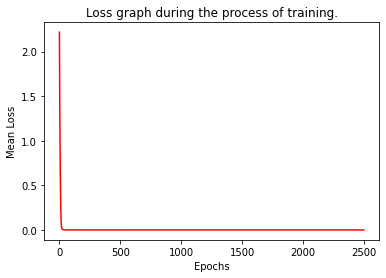

training finished.


In [ ]:
#in order for the training to work, we carefully change some of the parameters of the already-made classes.
batch_size=32
mel_data = SpectrogramDataset(
    os.path.join(DATA_DIR, 'fma_genre_spectrograms_beat/'), 
    class_mapping=CLASS_MAPPING, 
    spectype='mel'
)
train_loader_mel, val_loader_mel = torch_train_val_split(mel_data, batch_size ,batch_size, val_size=1/3)
input_features = mel_data[0][0].shape[1] # insert the used dataset here.
input_timesteps = mel_data[0][0].shape[0] # insert the used dataset here
conv_channels = [1,4,16,32,64]
kernels = [3,3,3,3]
maxpools = [3,3,3,3]
lin_channels = [128, 10] # 10 corresponds to number of classes
dropout = 0.0
batchnorm = True
# -------------------
learning_rate = 0.001
weight_decay = 1e-6
patience = -1
overfit_batch = True

epochs = 500

model = CNNBackbone(input_features = input_features, input_timesteps = input_timesteps,
                  conv_channels = conv_channels, kernels = kernels, maxpools = maxpools,
                  lin_channels = lin_channels, dropout = dropout, batchnorm = batchnorm)
model.double()
model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 

# Overfit the model
train_losses_overfit, val_losses_overfit = train(model, train_loader_mel, val_loader_mel, optimizer, epochs, device=device, overfit_batch=overfit_batch, patience=patience)


In [29]:
import gc

del train_loader_mel
del val_loader_mel
del train_losses_overfit
del val_losses_overfit
gc.collect()

11837

In [30]:
'''
batch_size = 32

mel_data = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', class_mapping=CLASS_MAPPING, spectype='mel')
train_loader_mel, val_loader_mel = torch_train_val_split(mel_data, batch_size ,batch_size, val_size=1/3)

mel_data_test = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', train=False, class_mapping=CLASS_MAPPING, spectype='mel')
test_loader_mel = DataLoader(mel_data_test, batch_size = batch_size)

input_features = mel_data[0][0].shape[1]#input_dimensions, since melograms are :128
input_timesteps = mel_data[0][0].shape[0]
conv_channels = [1,16,64,256,512]
kernels = [3,3,3,3]
maxpools = [3,3,3,3]
lin_channels = [128,64,10]
dropout = 0.25
learning_rate = 0.0001
weight_decay = 1e-5
patience = 12
overfit_batch = False

epochs = 2500

print('initializing the model')
model_mel_conv = CNNBackbone(input_features = input_features, input_timesteps = input_timesteps,
                    conv_channels = conv_channels, kernels = kernels, maxpools = maxpools,
                    lin_channels = lin_channels, dropout = dropout, batchnorm=False)
model_mel_conv.double()
model_mel_conv.to(device)
#choosing loss function and optimizer (based on what we were told)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mel_conv.parameters(), lr = learning_rate, weight_decay = weight_decay)

# Train the model
train_losses_mel_conv, val_losses_mel_conv = train(model_mel_conv, train_loader_mel, val_loader_mel, optimizer, epochs, device=device, overfit_batch=overfit_batch, patience=patience, temp = 10)
predictions, labels = evaluate(model_mel_conv, test_loader_mel, device=device)

y_true_mel = np.concatenate(labels, axis=0)
y_pred_mel = np.concatenate(predictions, axis=0)

print(classification_report(y_true_mel, y_pred_mel))
title = 'Train and Val losses using mel data'
plot_losses(train_losses_mel_conv, val_losses_mel_conv, title)
'''

"\nbatch_size = 32\n\nmel_data = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', class_mapping=CLASS_MAPPING, spectype='mel')\ntrain_loader_mel, val_loader_mel = torch_train_val_split(mel_data, batch_size ,batch_size, val_size=1/3)\n\nmel_data_test = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', train=False, class_mapping=CLASS_MAPPING, spectype='mel')\ntest_loader_mel = DataLoader(mel_data_test, batch_size = batch_size)\n\ninput_features = mel_data[0][0].shape[1]#input_dimensions, since melograms are :128\ninput_timesteps = mel_data[0][0].shape[0]\nconv_channels = [1,16,64,256,512]\nkernels = [3,3,3,3]\nmaxpools = [3,3,3,3]\nlin_channels = [128,64,10]\ndropout = 0.25\nlearning_rate = 0.0001\nweight_decay = 1e-5\npatience = 12\noverfit_batch = False\n\nepochs = 2500\n\nprint('initializing the model')\nmodel_mel_conv = CNNBackbone(input_features = input_features, input_timesteps = i

In [31]:
'''
import gc

del mel_data
del train_loader_mel
del val_loader_mel
gc.collect()
'''

'\nimport gc\n\ndel mel_data\ndel train_loader_mel\ndel val_loader_mel\ngc.collect()\n'

In [32]:
'''
batch_size = 32

fused_data = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', class_mapping=CLASS_MAPPING, spectype='both')
train_loader_fused, val_loader_fused = torch_train_val_split(fused_data, batch_size ,batch_size, val_size=1/3)

fused_data_test = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', train=False, class_mapping=CLASS_MAPPING, spectype='both')
test_loader_fused = DataLoader(fused_data_test, batch_size = batch_size)

input_features = fused_data[0][0].shape[1]#input_dimensions, since melograms are :128
input_timesteps = fused_data[0][0].shape[0]
conv_channels = [1,16,64,256,512]
kernels = [3,3,3,3]
maxpools = [3,3,3,3]
lin_channels = [128,64,10]
dropout = 0.25
learning_rate = 0.0001
weight_decay = 1e-5
patience = 12
overfit_batch = False

epochs = 2500

print('initializing the model')
model_fused_conv = CNNBackbone(input_features = input_features, input_timesteps = input_timesteps,
                    conv_channels = conv_channels, kernels = kernels, maxpools = maxpools,
                    lin_channels = lin_channels, dropout = dropout, batchnorm=False)
model_fused_conv.double()
model_fused_conv.to(device)
#choosing loss function and optimizer (based on what we were told)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_fused_conv.parameters(), lr = learning_rate, weight_decay = weight_decay)

#Train the model
train_losses_fused_conv, val_losses_fused_conv = train(model_fused_conv, train_loader_fused, val_loader_fused, optimizer, epochs, device=device, overfit_batch=overfit_batch, patience=patience, temp = 10)
predictions, labels = evaluate(model_fused_conv, test_loader_fused, device=device)\
'''

"\nbatch_size = 32\n\nfused_data = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', class_mapping=CLASS_MAPPING, spectype='both')\ntrain_loader_fused, val_loader_fused = torch_train_val_split(fused_data, batch_size ,batch_size, val_size=1/3)\n\nfused_data_test = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', train=False, class_mapping=CLASS_MAPPING, spectype='both')\ntest_loader_fused = DataLoader(fused_data_test, batch_size = batch_size)\n\ninput_features = fused_data[0][0].shape[1]#input_dimensions, since melograms are :128\ninput_timesteps = fused_data[0][0].shape[0]\nconv_channels = [1,16,64,256,512]\nkernels = [3,3,3,3]\nmaxpools = [3,3,3,3]\nlin_channels = [128,64,10]\ndropout = 0.25\nlearning_rate = 0.0001\nweight_decay = 1e-5\npatience = 12\noverfit_batch = False\n\nepochs = 2500\n\nprint('initializing the model')\nmodel_fused_conv = CNNBackbone(input_features = input_feature

In [33]:
'''
y_true_fused = np.concatenate(labels, axis=0)
y_pred_fused = np.concatenate(predictions, axis=0)

print(classification_report(y_true_fused, y_pred_fused))
title = 'Train and Val losses using fused data'
plot_losses(train_losses_fused_conv, val_losses_fused_conv, title)
'''

"\ny_true_fused = np.concatenate(labels, axis=0)\ny_pred_fused = np.concatenate(predictions, axis=0)\n\nprint(classification_report(y_true_fused, y_pred_fused))\ntitle = 'Train and Val losses using fused data'\nplot_losses(train_losses_fused_conv, val_losses_fused_conv, title)\n"

In [34]:
'''
batch_size = 32

mel_data = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', class_mapping=CLASS_MAPPING, spectype='mel')

chroma_cnn_data = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', class_mapping=CLASS_MAPPING, spectype='chroma')
train_loader_chroma_cnn, val_loader_chroma_cnn = torch_train_val_split(chroma_cnn_data, batch_size ,batch_size, val_size=1/3)

chroma_cnn_data_test = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', train=False, class_mapping=CLASS_MAPPING, spectype='chroma')
test_loader_chroma_cnn = DataLoader(chroma_cnn_data_test, batch_size = batch_size)

input_features = mel_data[0][0].shape[1]
input_timesteps = mel_data[0][0].shape[0]
conv_channels = [1,16,64,256,512]
kernels = [3,3,3,3]
maxpools = [3,3,3,3]
lin_channels = [128,64,10]
dropout = 0.25
learning_rate = 0.0001
weight_decay = 1e-5
patience = 12
overfit_batch = False

epochs = 2500

print('initializing the model')
model_chroma_conv = CNNBackbone(input_features = input_features, input_timesteps = input_timesteps,
                    conv_channels = conv_channels, kernels = kernels, maxpools = maxpools,
                    lin_channels = lin_channels, dropout = dropout, batchnorm=False)
model_chroma_conv.double()
model_chroma_conv.to(device)
#choosing loss function and optimizer (based on what we were told)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_chroma_conv.parameters(), lr = learning_rate, weight_decay = weight_decay)

#Train the model
train_losses_chroma_conv, val_losses_chroma_conv = train(model_chroma_conv, train_loader_chroma_cnn, val_loader_chroma_cnn, optimizer, epochs, device=device, overfit_batch=overfit_batch, patience=patience, temp = 10)
predictions_chroma_cnn, labels_chroma_cnn = evaluate(model_chroma_conv, test_loader_chroma_cnn, device=device)
'''

"\nbatch_size = 32\n\nmel_data = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', class_mapping=CLASS_MAPPING, spectype='mel')\n\nchroma_cnn_data = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', class_mapping=CLASS_MAPPING, spectype='chroma')\ntrain_loader_chroma_cnn, val_loader_chroma_cnn = torch_train_val_split(chroma_cnn_data, batch_size ,batch_size, val_size=1/3)\n\nchroma_cnn_data_test = SpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', train=False, class_mapping=CLASS_MAPPING, spectype='chroma')\ntest_loader_chroma_cnn = DataLoader(chroma_cnn_data_test, batch_size = batch_size)\n\ninput_features = mel_data[0][0].shape[1]\ninput_timesteps = mel_data[0][0].shape[0]\nconv_channels = [1,16,64,256,512]\nkernels = [3,3,3,3]\nmaxpools = [3,3,3,3]\nlin_channels = [128,64,10]\ndropout = 0.25\nlearning_rate = 0.0001\nweight_decay = 1e-5\n

In [35]:
'''
y_true_chroma = np.concatenate(labels_chroma_cnn, axis=0)
y_pred_chroma = np.concatenate(predictions_chroma_cnn, axis=0)

print(classification_report(y_true_chroma, y_pred_chroma))
title = 'Train and Val losses using chroma data'
plot_losses(train_losses_chroma_conv, val_losses_chroma_conv, title)
'''

"\ny_true_chroma = np.concatenate(labels_chroma_cnn, axis=0)\ny_pred_chroma = np.concatenate(predictions_chroma_cnn, axis=0)\n\nprint(classification_report(y_true_chroma, y_pred_chroma))\ntitle = 'Train and Val losses using chroma data'\nplot_losses(train_losses_chroma_conv, val_losses_chroma_conv, title)\n"

In [36]:
from scipy.stats import spearmanr

In [95]:
#we have to remake the split function due to the fact that there are no labels for the test set. Therefore, we need to use part of the train set to evaluate our work.
def torch_train_val_test_split(dataset, batch_train, batch_eval, val_size = 0.28, test_size = 0.12, shuffle=True, seed = 42):
    
    # Creating data indices for training and validation splits:
    # We have to enter a seed for debugging reasons.
    
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    test_split = int(np.floor(test_size * dataset_size))
    
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
   
    test_indices = indices[:test_split]  
    val_indices = indices[test_split:val_split+test_split]
    train_indices = indices[val_split+test_split:]
    
    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(dataset, batch_size = batch_train, sampler = train_sampler)
    val_loader = DataLoader(dataset, batch_size = batch_eval, sampler = val_sampler)
    test_loader = DataLoader(dataset, batch_size = batch_eval, sampler = test_sampler)
    
    return train_loader, val_loader, test_loader

In [38]:
#we have to remake the evaluation function because 
#regression models predict a single continuous value, whereas classification models predict a class label.

def regression_evaluation(model, test_dataloader, device="cuda"):
    
    model.eval()
    predictions = [] # predicted values
    labels = [] # ground truth
    
    with torch.no_grad():    
        for batch in test_dataloader:
            
            x_batch, y_batch, x_len = batch
                
            # Move to device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            if isinstance(model, LSTMBackbone):
                
                yhat = model(x_batch, x_len)
                
            elif isinstance(model, CNNBackbone):
                
                yhat = model(x_batch)                
                
            yhat = torch.flatten(yhat)
            predictions.append(yhat.cpu().numpy())
            labels.append(y_batch.cpu().numpy())
    
    return predictions, labels  # Return the model predictions

In [90]:
class RegressionSpectrogramDataset(Dataset):
    def __init__(
        self, path, train = True, max_length = -1, spectype = 'both', regtype = 'V'
    ):
        
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        
        self.regtype = regtype
        self.spectype = spectype
        
        self.index = os.path.join(path, f"{t}_labels.txt")
        self.files, labels = self.get_files_labels(self.index)
        
        self.feats = [read_spectrogram(os.path.join(p, f+".fused.full.npy"), spectype=self.spectype) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        
        self.labels = np.array(labels).astype("float64")
        
    def get_files_labels(self, txt):
        
        with open(txt, "r") as fd:
            
            lines = [l.rstrip().split('\t') for l in fd.readlines()[1:]]
            
        files, labels = [], []
        
        for l in lines:
            
            l = l[0].split(",")
            k = l[1:]
            k = list(map(float,k))
            files.append(l[0])
            
            if self.regtype=='V':
                
                labels.append(k[0])
                
            elif self.regtype=='E':
                
                labels.append(k[1])
                
            elif self.regtype=='D':
                
                labels.append(k[2])
                
            else:
                
                labels.append(k)
                
        return files, labels

    def __getitem__(self, item):
        # TODO: Inspect output and comment on how the output is formatted
        length = min(self.lengths[item], self.max_length)
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item], length

    def __len__(self):
        return len(self.labels)

In [ ]:
#valence
reg_mel_beat_data = RegressionSpectrogramDataset(
    os.path.join(DATA_DIR, 'multitask_dataset/'), 
    spectype='mel', 
    regtype='V'
)

In [41]:
batch_size = 32
train_beat_reg_mel, val_beat_reg_mel, test_beat_reg_mel = torch_train_val_test_split(reg_mel_beat_data, batch_size, batch_size, val_size = 0.12, test_size = 0.28)

In [42]:
def plot_reg_results(y_true, y_pred, typemod, typefeat):
    plt.plot(y_true, y_pred, 'o', color='r')
    plt.title(f"Scatterplot for {typefeat} - {typemod}.")
    plt.ylabel('Predictions')
    plt.xlabel('Actual Values')
    plt.show()

In [43]:
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline

In [44]:
'''
input_features = reg_mel_beat_data[0][0].shape[1] # insert the used dataset here. These are practically 128 if mel, 12 if chroma and 140 if fused
input_timesteps = reg_mel_beat_data[0][0].shape[0] # insert the used dataset here
conv_channels = [1, 16, 64, 256, 512]
kernels = [3, 3, 3, 3]
maxpools = [2, 2, 2, 2]
lin_channels = [128, 64, 1]
dropout = 0.25
learning_rate = 0.00001
weight_decay = 1e-5
patience = 12
overfit_batch = False

epochs = 2500

model_cnn_reg_v = CNNBackbone(input_features = input_features, input_timesteps = input_timesteps,
                    conv_channels = conv_channels, kernels = kernels, maxpools = maxpools,
                    lin_channels = lin_channels, dropout = dropout, batchnorm=False)
model_cnn_reg_v.double()
model_cnn_reg_v.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_cnn_reg_v.parameters(), lr = learning_rate, weight_decay = weight_decay)
'''

'\ninput_features = reg_mel_beat_data[0][0].shape[1] # insert the used dataset here. These are practically 128 if mel, 12 if chroma and 140 if fused\ninput_timesteps = reg_mel_beat_data[0][0].shape[0] # insert the used dataset here\nconv_channels = [1, 16, 64, 256, 512]\nkernels = [3, 3, 3, 3]\nmaxpools = [2, 2, 2, 2]\nlin_channels = [128, 64, 1]\ndropout = 0.25\nlearning_rate = 0.00001\nweight_decay = 1e-5\npatience = 12\noverfit_batch = False\n\nepochs = 2500\n\nmodel_cnn_reg_v = CNNBackbone(input_features = input_features, input_timesteps = input_timesteps,\n                    conv_channels = conv_channels, kernels = kernels, maxpools = maxpools,\n                    lin_channels = lin_channels, dropout = dropout, batchnorm=False)\nmodel_cnn_reg_v.double()\nmodel_cnn_reg_v.to(device)\nloss_function = nn.MSELoss()\noptimizer = torch.optim.Adam(model_cnn_reg_v.parameters(), lr = learning_rate, weight_decay = weight_decay)\n'

In [45]:
'''
train_losses_reg_cnn_val, val_losses_reg_cnn_val = train(model_cnn_reg_v, train_beat_reg_mel, val_beat_reg_mel, optimizer, epochs, 
                                     device = device, overfit_batch = overfit_batch, patience = patience, 
                                     temp = 10)
'''

'\ntrain_losses_reg_cnn_val, val_losses_reg_cnn_val = train(model_cnn_reg_v, train_beat_reg_mel, val_beat_reg_mel, optimizer, epochs, \n                                     device = device, overfit_batch = overfit_batch, patience = patience, \n                                     temp = 10)\n'

In [46]:
'''
predictions_cnn_val, labels_cnn_val = regression_evaluation(model_cnn_reg_v, test_beat_reg_mel, device=device)
y_true = np.concatenate(labels_cnn_val, axis=0)
y_pred = np.concatenate(predictions_cnn_val, axis=0)
'''

'\npredictions_cnn_val, labels_cnn_val = regression_evaluation(model_cnn_reg_v, test_beat_reg_mel, device=device)\ny_true = np.concatenate(labels_cnn_val, axis=0)\ny_pred = np.concatenate(predictions_cnn_val, axis=0)\n'

In [47]:
'''
typefeat = 'Valence'
typemod = 'CNN'
plot_reg_results(y_true, y_pred, typemod, typefeat)

result_val_cnn = spearmanr(y_true, y_pred)
print(result_val_cnn)
'''

"\ntypefeat = 'Valence'\ntypemod = 'CNN'\nplot_reg_results(y_true, y_pred, typemod, typefeat)\n\nresult_val_cnn = spearmanr(y_true, y_pred)\nprint(result_val_cnn)\n"

In [48]:
'''
reg_en_beat_data = RegressionSpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset/', spectype='mel', regtype='E')
batch_size = 32
train_beat_reg_en, val_beat_reg_en, test_beat_reg_en = torch_train_val_test_split(reg_en_beat_data, batch_size, batch_size, val_size = 0.12, test_size = 0.28)
'''

"\nreg_en_beat_data = RegressionSpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset/', spectype='mel', regtype='E')\nbatch_size = 32\ntrain_beat_reg_en, val_beat_reg_en, test_beat_reg_en = torch_train_val_test_split(reg_en_beat_data, batch_size, batch_size, val_size = 0.12, test_size = 0.28)\n"

In [49]:
'''
input_features = reg_en_beat_data[0][0].shape[1] # insert the used dataset here. These are practically 128 if mel, 12 if chroma and 140 if fused
input_timesteps = reg_en_beat_data[0][0].shape[0] # insert the used dataset here
conv_channels = [1, 16, 64, 256, 512]
kernels = [3, 3, 3, 3]
maxpools = [2, 2, 2, 2]
lin_channels = [128, 64, 1]
dropout = 0.25
learning_rate = 0.00001
weight_decay = 1e-5
patience = 12
overfit_batch = False

epochs = 2500

model_cnn_reg_en = CNNBackbone(input_features = input_features, input_timesteps = input_timesteps,
                    conv_channels = conv_channels, kernels = kernels, maxpools = maxpools,
                    lin_channels = lin_channels, dropout = dropout, batchnorm=False)
model_cnn_reg_en.double()
model_cnn_reg_en.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_cnn_reg_en.parameters(), lr = learning_rate, weight_decay = weight_decay)
'''

'\ninput_features = reg_en_beat_data[0][0].shape[1] # insert the used dataset here. These are practically 128 if mel, 12 if chroma and 140 if fused\ninput_timesteps = reg_en_beat_data[0][0].shape[0] # insert the used dataset here\nconv_channels = [1, 16, 64, 256, 512]\nkernels = [3, 3, 3, 3]\nmaxpools = [2, 2, 2, 2]\nlin_channels = [128, 64, 1]\ndropout = 0.25\nlearning_rate = 0.00001\nweight_decay = 1e-5\npatience = 12\noverfit_batch = False\n\nepochs = 2500\n\nmodel_cnn_reg_en = CNNBackbone(input_features = input_features, input_timesteps = input_timesteps,\n                    conv_channels = conv_channels, kernels = kernels, maxpools = maxpools,\n                    lin_channels = lin_channels, dropout = dropout, batchnorm=False)\nmodel_cnn_reg_en.double()\nmodel_cnn_reg_en.to(device)\nloss_function = nn.MSELoss()\noptimizer = torch.optim.Adam(model_cnn_reg_en.parameters(), lr = learning_rate, weight_decay = weight_decay)\n'

In [50]:
'''
train_losses_reg_cnn_en, val_losses_reg_cnn_en = train(model_cnn_reg_en, train_beat_reg_en, val_beat_reg_en, optimizer, epochs, 
                                     device = device, overfit_batch = overfit_batch, patience = patience, 
                                     temp = 10)
'''

'\ntrain_losses_reg_cnn_en, val_losses_reg_cnn_en = train(model_cnn_reg_en, train_beat_reg_en, val_beat_reg_en, optimizer, epochs, \n                                     device = device, overfit_batch = overfit_batch, patience = patience, \n                                     temp = 10)\n'

In [51]:
'''
predictions_cnn_en, labels_cnn_en = regression_evaluation(model_cnn_reg_en, test_beat_reg_en, device=device)
y_true_en_cnn = np.concatenate(labels_cnn_en, axis=0)
y_pred_en_cnn = np.concatenate(predictions_cnn_en, axis=0)
'''

'\npredictions_cnn_en, labels_cnn_en = regression_evaluation(model_cnn_reg_en, test_beat_reg_en, device=device)\ny_true_en_cnn = np.concatenate(labels_cnn_en, axis=0)\ny_pred_en_cnn = np.concatenate(predictions_cnn_en, axis=0)\n'

In [52]:
'''
typefeat = 'Energy'
typemod = 'CNN'
plot_reg_results(y_true_en_cnn, y_pred_en_cnn, typemod, typefeat)

result_en_cnn = spearmanr(y_true_en_cnn, y_pred_en_cnn)
print(result_en_cnn)
'''

"\ntypefeat = 'Energy'\ntypemod = 'CNN'\nplot_reg_results(y_true_en_cnn, y_pred_en_cnn, typemod, typefeat)\n\nresult_en_cnn = spearmanr(y_true_en_cnn, y_pred_en_cnn)\nprint(result_en_cnn)\n"

In [53]:
'''
reg_dn_beat_data = RegressionSpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset/', spectype='mel', regtype='D')
batch_size = 32
train_beat_reg_dn, val_beat_reg_dn, test_beat_reg_dn = torch_train_val_test_split(reg_dn_beat_data, batch_size, batch_size, val_size = 0.12, test_size = 0.28)
'''

"\nreg_dn_beat_data = RegressionSpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset/', spectype='mel', regtype='D')\nbatch_size = 32\ntrain_beat_reg_dn, val_beat_reg_dn, test_beat_reg_dn = torch_train_val_test_split(reg_dn_beat_data, batch_size, batch_size, val_size = 0.12, test_size = 0.28)\n"

In [54]:
'''
input_features = reg_dn_beat_data[0][0].shape[1] # insert the used dataset here. These are practically 128 if mel, 12 if chroma and 140 if fused
input_timesteps = reg_dn_beat_data[0][0].shape[0] # insert the used dataset here
conv_channels = [1, 16, 64, 256, 512]
kernels = [3, 3, 3, 3]
maxpools = [2, 2, 2, 2]
lin_channels = [128, 64, 1]
dropout = 0.25
learning_rate = 0.00001
weight_decay = 1e-5
patience = 12
overfit_batch = False

epochs = 2500

model_cnn_reg_dn = CNNBackbone(input_features = input_features, input_timesteps = input_timesteps,
                    conv_channels = conv_channels, kernels = kernels, maxpools = maxpools,
                    lin_channels = lin_channels, dropout = dropout, batchnorm=False)
model_cnn_reg_dn.double()
model_cnn_reg_dn.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_cnn_reg_dn.parameters(), lr = learning_rate, weight_decay = weight_decay)
'''

'\ninput_features = reg_dn_beat_data[0][0].shape[1] # insert the used dataset here. These are practically 128 if mel, 12 if chroma and 140 if fused\ninput_timesteps = reg_dn_beat_data[0][0].shape[0] # insert the used dataset here\nconv_channels = [1, 16, 64, 256, 512]\nkernels = [3, 3, 3, 3]\nmaxpools = [2, 2, 2, 2]\nlin_channels = [128, 64, 1]\ndropout = 0.25\nlearning_rate = 0.00001\nweight_decay = 1e-5\npatience = 12\noverfit_batch = False\n\nepochs = 2500\n\nmodel_cnn_reg_dn = CNNBackbone(input_features = input_features, input_timesteps = input_timesteps,\n                    conv_channels = conv_channels, kernels = kernels, maxpools = maxpools,\n                    lin_channels = lin_channels, dropout = dropout, batchnorm=False)\nmodel_cnn_reg_dn.double()\nmodel_cnn_reg_dn.to(device)\nloss_function = nn.MSELoss()\noptimizer = torch.optim.Adam(model_cnn_reg_dn.parameters(), lr = learning_rate, weight_decay = weight_decay)\n'

In [55]:
'''
train_losses_reg_cnn_dn, val_losses_reg_cnn_dn = train(model_cnn_reg_dn, train_beat_reg_dn, val_beat_reg_dn, optimizer, epochs, 
                                     device = device, overfit_batch = overfit_batch, patience = patience, 
                                     temp = 10)
'''

'\ntrain_losses_reg_cnn_dn, val_losses_reg_cnn_dn = train(model_cnn_reg_dn, train_beat_reg_dn, val_beat_reg_dn, optimizer, epochs, \n                                     device = device, overfit_batch = overfit_batch, patience = patience, \n                                     temp = 10)\n'

In [56]:
'''
predictions_cnn_dn, labels_cnn_dn = regression_evaluation(model_cnn_reg_dn, test_beat_reg_dn, device=device)
y_true_dn_cnn = np.concatenate(labels_cnn_dn, axis=0)
y_pred_dn_cnn = np.concatenate(predictions_cnn_dn, axis=0)
'''

'\npredictions_cnn_dn, labels_cnn_dn = regression_evaluation(model_cnn_reg_dn, test_beat_reg_dn, device=device)\ny_true_dn_cnn = np.concatenate(labels_cnn_dn, axis=0)\ny_pred_dn_cnn = np.concatenate(predictions_cnn_dn, axis=0)\n'

In [57]:
'''
emotion = 'Danceability'
modeltype = 'CNN'
plot_reg_results(y_true_dn_cnn, y_pred_dn_cnn, modeltype, emotion)

result_dn_cnn = spearmanr(y_true_dn_cnn, y_pred_dn_cnn)
print(result_dn_cnn)
'''

"\nemotion = 'Danceability'\nmodeltype = 'CNN'\nplot_reg_results(y_true_dn_cnn, y_pred_dn_cnn, modeltype, emotion)\n\nresult_dn_cnn = spearmanr(y_true_dn_cnn, y_pred_dn_cnn)\nprint(result_dn_cnn)\n"

In [58]:
from sklearn.model_selection import KFold, GridSearchCV

In [59]:
'''
def grid_search(train_dataloader, val_dataloader):
    
    best_model = None
    best_loss = float('inf')
    best_params = None
    training_losses = []
    validation_losses = []
    input_dim = 128
    output_dim = 1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bidirectional = True
    dropout = 0.2
    epochs = 2000
    temp = 10
    weight_decay = 1e-6
    patience = 12
    overfit_batch = False 
        
    param_grid = {'rnn_size': [200, 300, 600],
    'num_layers': [2, 3, 4],
    'learning_rate': [1e-05, 5e-06],
    'loss_function': [nn.MSELoss(), nn.L1Loss(), nn.SmoothL1Loss()]}
    grid = ParameterGrid(param_grid)
    
    for params in grid:
        
        model = LSTMBackbone(input_dim = input_dim, output_dim = output_dim, rnn_size = params['rnn_size'], num_layers = params['num_layers'], bidirectional = bidirectional, dropout = dropout)
        model = model.double()
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr = params['learning_rate'], weight_decay = weight_decay)
        loss_function = params['loss_function']

        train_losses, val_losses = train(model, train_dataloader, val_dataloader, optimizer, epochs = epochs, device = device, overfit_batch = overfit_batch, patience = patience, temp = temp)

        val_loss = val_losses[-1]

        if val_loss < best_loss:

            best_loss = val_loss
            best_model = model
            best_params = params
            training_losses = train_losses
            validation_losses = val_losses
            
    return best_model, best_params, training_losses, validation_losses
'''

'\ndef grid_search(train_dataloader, val_dataloader):\n    \n    best_model = None\n    best_loss = float(\'inf\')\n    best_params = None\n    training_losses = []\n    validation_losses = []\n    input_dim = 128\n    output_dim = 1\n    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n    bidirectional = True\n    dropout = 0.2\n    epochs = 2000\n    temp = 10\n    weight_decay = 1e-6\n    patience = 12\n    overfit_batch = False \n        \n    param_grid = {\'rnn_size\': [200, 300, 600],\n    \'num_layers\': [2, 3, 4],\n    \'learning_rate\': [1e-05, 5e-06],\n    \'loss_function\': [nn.MSELoss(), nn.L1Loss(), nn.SmoothL1Loss()]}\n    grid = ParameterGrid(param_grid)\n    \n    for params in grid:\n        \n        model = LSTMBackbone(input_dim = input_dim, output_dim = output_dim, rnn_size = params[\'rnn_size\'], num_layers = params[\'num_layers\'], bidirectional = bidirectional, dropout = dropout)\n        model = model.double()\n        model = model.to(d

In [60]:
'''
#valence
reg_mel_beat_data_2 = RegressionSpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/', spectype='mel', regtype='V')
batch_size = 32
train_beat_reg_mel_2, val_beat_reg_mel_2, test_beat_reg_mel_2 = torch_train_val_test_split(reg_mel_beat_data_2, batch_size, batch_size, val_size = 0.12, test_size = 0.28)
'''

"\n#valence\nreg_mel_beat_data_2 = RegressionSpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/', spectype='mel', regtype='V')\nbatch_size = 32\ntrain_beat_reg_mel_2, val_beat_reg_mel_2, test_beat_reg_mel_2 = torch_train_val_test_split(reg_mel_beat_data_2, batch_size, batch_size, val_size = 0.12, test_size = 0.28)\n"

In [61]:
'''
best_model_valence, best_params_valence, training_losses_valence, validation_losses_valence = grid_search(train_beat_reg_mel_2, val_beat_reg_mel_2)   
'''

'\nbest_model_valence, best_params_valence, training_losses_valence, validation_losses_valence = grid_search(train_beat_reg_mel_2, val_beat_reg_mel_2)   \n'

In [62]:
'''
print(best_params_valence)
'''

'\nprint(best_params_valence)\n'

In [63]:
'''
beat_mel_data = RegressionSpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/', spectype='mel', regtype='V')
train_beat_mel, val_beat_mel, test_beat_mel = torch_train_val_test_split(beat_mel_data, batch_size ,batch_size, val_size = 0.28, test_size = 0.12)

# LSTM
num_mel = 128
#num_chroma = 12
output_dim = 1 # regression
rnn_size = 100
num_layers = 2
dropout = 0.2
learning_rate = 0.00002
weight_decay = 1e-6
patience = 12
overfit_batch = False
bidirectional = True
verbose_ct = 1000

epochs = 2000


param_grid = {'rnn_size': [200, 600], 
              'num_layers' : [3, 5],
               'learning_rate': [1e-05, 5e-06],
               'loss_functions': [nn.MSELoss(), 
                                  nn.L1Loss(), 
                                  nn.SmoothL1Loss()]}

my_specs = []
my_losses = []

grid = ParameterGrid(param_grid)

for params in grid:
    curr_specs = [params['rnn_size'], params['num_layers'], params['learning_rate'], params['loss_functions']]
    model = LSTMBackbone(input_dim = num_mel, output_dim = output_dim, rnn_size = params['rnn_size'],
                         num_layers = params['num_layers'], bidirectional = bidirectional, dropout = dropout)
    model.double()
    model.to(device)
    loss_function = params['loss_functions']
    optimizer = torch.optim.Adam(model.parameters(), lr = params['learning_rate'], weight_decay = weight_decay)

    # Train the models
    train_losses, val_losses = train(model, train_beat_mel, val_beat_mel, optimizer, epochs, 
                                     device=device, overfit_batch=overfit_batch, patience=patience, 
                                     temp = 100)

    typemod = 'LSTM'
    title = f"Beat-Synced-Mel-{typemod}-Regression"

    # Evaluate the model
    predictions, labels = regression_evaluation(model, test_beat_mel, device=device)

    y_true = np.concatenate(labels, axis=0)
    y_pred = np.concatenate(predictions, axis=0)

    typefeat = 'Valence'
    plottitle = f'Beat-Synced-Mel-{typefeat}-{typemod}'
    # plot_reg_results(y_true,y_pred,typemod,typefeat,plottitle)

    result = spearmanr(y_true, y_pred)
    my_losses.append(result[0])
    my_specs.append(curr_specs)
    print(curr_specs)
    print(f"The Spearman's rank correlation measure is equal to {100*result[0]:.2f} with p-value = {result[1]:.4f}.")


my_data = [my_specs, my_losses]
grid_search_summary = pd.DataFrame(my_data)

# Show the results in an order of a descending Spearman correlation.

grid_search_summary.sort_values(by=1, axis=1, ascending=False).T
'''

'\nbeat_mel_data = RegressionSpectrogramDataset(\'/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/\', spectype=\'mel\', regtype=\'V\')\ntrain_beat_mel, val_beat_mel, test_beat_mel = torch_train_val_test_split(beat_mel_data, batch_size ,batch_size, val_size = 0.28, test_size = 0.12)\n\n# LSTM\nnum_mel = 128\n#num_chroma = 12\noutput_dim = 1 # regression\nrnn_size = 100\nnum_layers = 2\ndropout = 0.2\nlearning_rate = 0.00002\nweight_decay = 1e-6\npatience = 12\noverfit_batch = False\nbidirectional = True\nverbose_ct = 1000\n\nepochs = 2000\n\n\nparam_grid = {\'rnn_size\': [200, 600], \n              \'num_layers\' : [3, 5],\n               \'learning_rate\': [1e-05, 5e-06],\n               \'loss_functions\': [nn.MSELoss(), \n                                  nn.L1Loss(), \n                                  nn.SmoothL1Loss()]}\n\nmy_specs = []\nmy_losses = []\n\ngrid = ParameterGrid(param_grid)\n\nfor params in grid:\n    curr_specs = [params[\'rnn_size\'], p

In [64]:
'''
num_mel = 128
#num_chroma = 12
output_dim = 1 # regression
rnn_size = 100
num_layers = 2
dropout = 0.2
learning_rate = 0.00002
weight_decay = 1e-6
patience = 12
overfit_batch = False
bidirectional = True
verbose_ct = 1000

epochs = 2000
nn.SmoothL1Loss()

param_grid = {'rnn_size': [600], 
              'num_layers' : [3],
               'learning_rate': [1e-05],
               'loss_functions': [nn.SmoothL1Loss()]}

my_specs = []
my_losses = []
val_losses = []

grid = ParameterGrid(param_grid)

counter = 0

for params in grid:
    curr_specs = [params['rnn_size'], params['num_layers'], params['learning_rate'], params['loss_functions']]
    model = LSTMBackbone(input_dim = num_mel, output_dim = output_dim, rnn_size = params['rnn_size'],
                         num_layers = params['num_layers'], bidirectional = bidirectional, dropout = dropout)
    model.double()
    model.to(device)
    loss_function = params['loss_functions']
    optimizer = torch.optim.Adam(model.parameters(), lr = params['learning_rate'], weight_decay = weight_decay)

    # Train the model
    train_losses, val_losses = train(model, train_beat_mel, val_beat_mel, optimizer, epochs, 
                                     device=device, overfit_batch=overfit_batch, patience=patience, 
                                     temp = 100)
    
    last_v_loss = val_losses[len(val_losses)-1]

    typemod = 'LSTM'
    title = f"Beat-Synced-Mel-{typemod}-Regression"

    # Evaluate the model
    predictions, labels = regression_evaluation(model, test_beat_mel, device=device)

    y_true = np.concatenate(labels, axis=0)
    y_pred = np.concatenate(predictions, axis=0)

    typefeat = 'Valence'
    plottitle = f'Beat-Synced-Mel-{typefeat}-{typemod}'
    # plot_reg_results(y_true,y_pred,typemod,typefeat,plottitle)

    result = spearmanr(y_true, y_pred)
    my_losses.append(result[0])
    my_specs.append(curr_specs)
    val_losses.append(last_v_loss)
    print(curr_specs)
    print(f"The Spearman's rank correlation measure is equal to {100*result[0]:.2f} with p-value = {result[1]:.4f}.")
'''

'\nnum_mel = 128\n#num_chroma = 12\noutput_dim = 1 # regression\nrnn_size = 100\nnum_layers = 2\ndropout = 0.2\nlearning_rate = 0.00002\nweight_decay = 1e-6\npatience = 12\noverfit_batch = False\nbidirectional = True\nverbose_ct = 1000\n\nepochs = 2000\nnn.SmoothL1Loss()\n\nparam_grid = {\'rnn_size\': [600], \n              \'num_layers\' : [3],\n               \'learning_rate\': [1e-05],\n               \'loss_functions\': [nn.SmoothL1Loss()]}\n\nmy_specs = []\nmy_losses = []\nval_losses = []\n\ngrid = ParameterGrid(param_grid)\n\ncounter = 0\n\nfor params in grid:\n    curr_specs = [params[\'rnn_size\'], params[\'num_layers\'], params[\'learning_rate\'], params[\'loss_functions\']]\n    model = LSTMBackbone(input_dim = num_mel, output_dim = output_dim, rnn_size = params[\'rnn_size\'],\n                         num_layers = params[\'num_layers\'], bidirectional = bidirectional, dropout = dropout)\n    model.double()\n    model.to(device)\n    loss_function = params[\'loss_functions\']

In [65]:
'''
typemod = 'LSTM'
plot_reg_results(y_true,y_pred,typemod,typefeat)
'''

"\ntypemod = 'LSTM'\nplot_reg_results(y_true,y_pred,typemod,typefeat)\n"

In [66]:
'''
beat_mel_data = RegressionSpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/', spectype='mel', regtype='E')
train_beat_mel, val_beat_mel, test_beat_mel = torch_train_val_test_split(beat_mel_data, batch_size ,batch_size, val_size = 0.28, test_size = 0.12)

# LSTM
num_mel = 128
output_dim = 1 # regression
rnn_size = 100
num_layers = 2
dropout = 0.2
learning_rate = 0.00002
weight_decay = 1e-6
patience = 12
overfit_batch = False
bidirectional = True
verbose_ct = 1000

epochs = 2000

'''
#param_grid = {'rnn_size': [200, 600], 
              #'num_layers' : [2, 5],
               #'learning_rate': [1e-05, 5e-06],
               #'loss_functions': [nn.MSELoss(), 
                #                  nn.L1Loss(), 
                 #                 nn.SmoothL1Loss()]}
'''
param_grid = {'rnn_size': [200, 600], 
              'num_layers' : [2, 5],
               'learning_rate': [1e-05, 5e-06],
               'loss_functions': [nn.L1Loss(), 
                                  nn.SmoothL1Loss()]}

my_specs = []
my_losses = []

grid = ParameterGrid(param_grid)

for params in grid:
    curr_specs = [params['rnn_size'], params['num_layers'], params['learning_rate'], params['loss_functions']]
    model = LSTMBackbone(input_dim = num_mel, output_dim = output_dim, rnn_size = params['rnn_size'],
                         num_layers = params['num_layers'], bidirectional = bidirectional, dropout = dropout)
    model.double()
    model.to(device)
    loss_function = params['loss_functions']
    optimizer = torch.optim.Adam(model.parameters(), lr = params['learning_rate'], weight_decay = weight_decay)

    # Train the model
    train_losses, val_losses = train(model, train_beat_mel, val_beat_mel, optimizer, epochs, 
                                     device=device, overfit_batch=overfit_batch, patience=patience, 
                                     temp = 100)

    typemod = 'LSTM'
    title = f"Beat-Synced-Mel-{typemod}-Regression.pdf"
    # Plot the loss diagram
    # plot_losses(train_losses, val_losses, typemod, title)

    # Evaluate the model
    predictions, labels = regression_evaluation(model, test_beat_mel, device=device)

    y_true = np.concatenate(labels, axis=0)
    y_pred = np.concatenate(predictions, axis=0)

    typefeat = 'Energy'
    plottitle = f'Beat-Synced-Mel-{typefeat}-{typemod}'
    # plot_reg_results(y_true,y_pred,typemod,typefeat,plottitle)

    result = spearmanr(y_true, y_pred)
    my_losses.append(result[0])
    my_specs.append(curr_specs)
    print(curr_specs)
    print(f"The Spearman's rank correlation measure is equal to {100*result[0]:.2f} with p-value = {result[1]:.4f}.")


my_data = [my_specs, my_losses]
grid_search_summary = pd.DataFrame(my_data)

# Show the results in an order of a descending Spearman correlation.

grid_search_summary.sort_values(by=1, axis=1, ascending=False).T

'''

'\nparam_grid = {\'rnn_size\': [200, 600], \n              \'num_layers\' : [2, 5],\n               \'learning_rate\': [1e-05, 5e-06],\n               \'loss_functions\': [nn.L1Loss(), \n                                  nn.SmoothL1Loss()]}\n\nmy_specs = []\nmy_losses = []\n\ngrid = ParameterGrid(param_grid)\n\nfor params in grid:\n    curr_specs = [params[\'rnn_size\'], params[\'num_layers\'], params[\'learning_rate\'], params[\'loss_functions\']]\n    model = LSTMBackbone(input_dim = num_mel, output_dim = output_dim, rnn_size = params[\'rnn_size\'],\n                         num_layers = params[\'num_layers\'], bidirectional = bidirectional, dropout = dropout)\n    model.double()\n    model.to(device)\n    loss_function = params[\'loss_functions\']\n    optimizer = torch.optim.Adam(model.parameters(), lr = params[\'learning_rate\'], weight_decay = weight_decay)\n\n    # Train the model\n    train_losses, val_losses = train(model, train_beat_mel, val_beat_mel, optimizer, epochs, \n   

In [67]:
'''
num_mel = 128
#num_chroma = 12
output_dim = 1 # regression
rnn_size = 100
num_layers = 2
dropout = 0.2
learning_rate = 0.00002
weight_decay = 1e-6
patience = 12
overfit_batch = False
bidirectional = True
verbose_ct = 1000

epochs = 2000
nn.SmoothL1Loss()

param_grid = {'rnn_size': [600], 
              'num_layers' : [5],
               'learning_rate': [5e-06],
               'loss_functions': [nn.SmoothL1Loss()]}

my_specs = []
my_losses = []
val_losses = []

grid = ParameterGrid(param_grid)

counter = 0

for params in grid:
    curr_specs = [params['rnn_size'], params['num_layers'], params['learning_rate'], params['loss_functions']]
    model = LSTMBackbone(input_dim = num_mel, output_dim = output_dim, rnn_size = params['rnn_size'],
                         num_layers = params['num_layers'], bidirectional = bidirectional, dropout = dropout)
    model.double()
    model.to(device)
    loss_function = params['loss_functions']
    optimizer = torch.optim.Adam(model.parameters(), lr = params['learning_rate'], weight_decay = weight_decay)

    # Train the model
    train_losses, val_losses = train(model, train_beat_mel, val_beat_mel, optimizer, epochs, 
                                     device=device, overfit_batch=overfit_batch, patience=patience, 
                                     temp = 100)
    
    last_v_loss = val_losses[len(val_losses)-1]

    typemod = 'LSTM'
    title = f"Beat-Synced-Mel-{typemod}-Regression"

    # Evaluate the model
    predictions, labels = regression_evaluation(model, test_beat_mel, device=device)

    y_true = np.concatenate(labels, axis=0)
    y_pred = np.concatenate(predictions, axis=0)

    typefeat = 'Energy'
    plottitle = f'Beat-Synced-Mel-{typefeat}-{typemod}'
    # plot_reg_results(y_true,y_pred,typemod,typefeat,plottitle)

    result = spearmanr(y_true, y_pred)
    my_losses.append(result[0])
    my_specs.append(curr_specs)
    val_losses.append(last_v_loss)
    print(curr_specs)
    print(f"The Spearman's rank correlation measure is equal to {100*result[0]:.2f} with p-value = {result[1]:.4f}.")
'''


'\nnum_mel = 128\n#num_chroma = 12\noutput_dim = 1 # regression\nrnn_size = 100\nnum_layers = 2\ndropout = 0.2\nlearning_rate = 0.00002\nweight_decay = 1e-6\npatience = 12\noverfit_batch = False\nbidirectional = True\nverbose_ct = 1000\n\nepochs = 2000\nnn.SmoothL1Loss()\n\nparam_grid = {\'rnn_size\': [600], \n              \'num_layers\' : [5],\n               \'learning_rate\': [5e-06],\n               \'loss_functions\': [nn.SmoothL1Loss()]}\n\nmy_specs = []\nmy_losses = []\nval_losses = []\n\ngrid = ParameterGrid(param_grid)\n\ncounter = 0\n\nfor params in grid:\n    curr_specs = [params[\'rnn_size\'], params[\'num_layers\'], params[\'learning_rate\'], params[\'loss_functions\']]\n    model = LSTMBackbone(input_dim = num_mel, output_dim = output_dim, rnn_size = params[\'rnn_size\'],\n                         num_layers = params[\'num_layers\'], bidirectional = bidirectional, dropout = dropout)\n    model.double()\n    model.to(device)\n    loss_function = params[\'loss_functions\']

In [68]:
'''
typemod = 'LSTM'
plot_reg_results(y_true,y_pred,typemod,typefeat)
'''

"\ntypemod = 'LSTM'\nplot_reg_results(y_true,y_pred,typemod,typefeat)\n"

In [69]:
'''
beat_mel_data_dance = RegressionSpectrogramDataset('/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/', spectype='mel', regtype='D')
train_beat_mel_dance, val_beat_mel_dance, test_beat_mel_dance = torch_train_val_test_split(beat_mel_data_dance, batch_size ,batch_size, val_size = 0.28, test_size = 0.12)

# LSTM
num_mel = 128
#num_chroma = 12
output_dim = 1 # regression
rnn_size = 100
num_layers = 2
dropout = 0.2
learning_rate = 0.00002
weight_decay = 1e-6
patience = 12
overfit_batch = False
bidirectional = True
verbose_ct = 1000

epochs = 2000


'''
#param_grid = {'rnn_size': [200, 600], 
              #'num_layers' : [2, 5],
               #'learning_rate': [1e-05, 5e-06],
               #'loss_functions': [nn.MSELoss(), 
                #                  nn.L1Loss(), 
                 #                 nn.SmoothL1Loss()]}
'''
param_grid = {'rnn_size': [200, 600], 
              'num_layers' : [2, 5],
               'learning_rate': [1e-05, 5e-06],
               'loss_functions': [nn.L1Loss(), 
                                  nn.SmoothL1Loss()]}


my_specs = []
my_losses = []

grid = ParameterGrid(param_grid)

for params in grid:
    curr_specs = [params['rnn_size'], params['num_layers'], params['learning_rate'], params['loss_functions']]
    model = LSTMBackbone(input_dim = num_mel, output_dim = output_dim, rnn_size = params['rnn_size'],
                         num_layers = params['num_layers'], bidirectional = bidirectional, dropout = dropout)
    model.double()
    model.to(device)
    loss_function = params['loss_functions']
    optimizer = torch.optim.Adam(model.parameters(), lr = params['learning_rate'], weight_decay = weight_decay)

    # Train the model
    train_losses, val_losses = train(model, train_beat_mel_dance, val_beat_mel_dance, optimizer, epochs, 
                                     device=device, overfit_batch=overfit_batch, patience=patience, 
                                     temp = 100)

    typemod = 'LSTM'

    # Evaluate the model
    predictions, labels = regression_evaluation(model, test_beat_mel_dance, device=device)

    y_true = np.concatenate(labels, axis=0)
    y_pred = np.concatenate(predictions, axis=0)

    typefeat = 'Danceability'
    plottitle = f'Beat-Synced-Mel-{typefeat}-{typemod}'

    result = spearmanr(y_true, y_pred)
    my_losses.append(result[0])
    my_specs.append(curr_specs)
    print(curr_specs)
    print(f"The Spearman's rank correlation measure is equal to {100*result[0]:.2f} with p-value = {result[1]:.4f}.")


my_data = [my_specs, my_losses]
grid_search_summary = pd.DataFrame(my_data)

# Show the results in an order of a descending Spearman correlation.

grid_search_summary.sort_values(by=1, axis=1, ascending=False).T
'''


'\nparam_grid = {\'rnn_size\': [200, 600], \n              \'num_layers\' : [2, 5],\n               \'learning_rate\': [1e-05, 5e-06],\n               \'loss_functions\': [nn.L1Loss(), \n                                  nn.SmoothL1Loss()]}\n\n\nmy_specs = []\nmy_losses = []\n\ngrid = ParameterGrid(param_grid)\n\nfor params in grid:\n    curr_specs = [params[\'rnn_size\'], params[\'num_layers\'], params[\'learning_rate\'], params[\'loss_functions\']]\n    model = LSTMBackbone(input_dim = num_mel, output_dim = output_dim, rnn_size = params[\'rnn_size\'],\n                         num_layers = params[\'num_layers\'], bidirectional = bidirectional, dropout = dropout)\n    model.double()\n    model.to(device)\n    loss_function = params[\'loss_functions\']\n    optimizer = torch.optim.Adam(model.parameters(), lr = params[\'learning_rate\'], weight_decay = weight_decay)\n\n    # Train the model\n    train_losses, val_losses = train(model, train_beat_mel_dance, val_beat_mel_dance, optimizer,

In [70]:
'''
num_mel = 128
#num_chroma = 12
output_dim = 1 # regression
rnn_size = 100
num_layers = 2
dropout = 0.2
learning_rate = 0.00002
weight_decay = 1e-6
patience = 12
overfit_batch = False
bidirectional = True
verbose_ct = 1000

epochs = 2000
nn.SmoothL1Loss()

param_grid = {'rnn_size': [600], 
              'num_layers' : [5],
              'learning_rate': [1e-05],
              'loss_functions': [nn.L1Loss()]}

my_specs = []
my_losses = []
val_losses = []

grid = ParameterGrid(param_grid)

counter = 0

for params in grid:
    curr_specs = [params['rnn_size'], params['num_layers'], params['learning_rate'], params['loss_functions']]
    model = LSTMBackbone(input_dim = num_mel, output_dim = output_dim, rnn_size = params['rnn_size'],
                         num_layers = params['num_layers'], bidirectional = bidirectional, dropout = dropout)
    model.double()
    model.to(device)
    loss_function = params['loss_functions']
    optimizer = torch.optim.Adam(model.parameters(), lr = params['learning_rate'], weight_decay = weight_decay)

    # Train the model
    train_losses, val_losses = train(model, train_beat_mel, val_beat_mel, optimizer, epochs, 
                                     device=device, overfit_batch=overfit_batch, patience=patience, 
                                     temp = 100)
    
    last_v_loss = val_losses[len(val_losses)-1]

    typemod = 'LSTM'
    title = f"Beat-Synced-Mel-{typemod}-Regression"

    # Evaluate the model
    predictions, labels = regression_evaluation(model, test_beat_mel, device=device)

    y_true = np.concatenate(labels, axis=0)
    y_pred = np.concatenate(predictions, axis=0)

    typefeat = 'Danceability'
    plottitle = f'Beat-Synced-Mel-{typefeat}-{typemod}'
    # plot_reg_results(y_true,y_pred,typemod,typefeat,plottitle)

    result = spearmanr(y_true, y_pred)
    my_losses.append(result[0])
    my_specs.append(curr_specs)
    val_losses.append(last_v_loss)
    print(curr_specs)
    print(f"The Spearman's rank correlation measure is equal to {100*result[0]:.2f} with p-value = {result[1]:.4f}.")
'''

'\nnum_mel = 128\n#num_chroma = 12\noutput_dim = 1 # regression\nrnn_size = 100\nnum_layers = 2\ndropout = 0.2\nlearning_rate = 0.00002\nweight_decay = 1e-6\npatience = 12\noverfit_batch = False\nbidirectional = True\nverbose_ct = 1000\n\nepochs = 2000\nnn.SmoothL1Loss()\n\nparam_grid = {\'rnn_size\': [600], \n              \'num_layers\' : [5],\n              \'learning_rate\': [1e-05],\n              \'loss_functions\': [nn.L1Loss()]}\n\nmy_specs = []\nmy_losses = []\nval_losses = []\n\ngrid = ParameterGrid(param_grid)\n\ncounter = 0\n\nfor params in grid:\n    curr_specs = [params[\'rnn_size\'], params[\'num_layers\'], params[\'learning_rate\'], params[\'loss_functions\']]\n    model = LSTMBackbone(input_dim = num_mel, output_dim = output_dim, rnn_size = params[\'rnn_size\'],\n                         num_layers = params[\'num_layers\'], bidirectional = bidirectional, dropout = dropout)\n    model.double()\n    model.to(device)\n    loss_function = params[\'loss_functions\']\n    op

In [71]:
'''
typemod = 'LSTM'
plot_reg_results(y_true,y_pred,typemod,typefeat)
'''


"\ntypemod = 'LSTM'\nplot_reg_results(y_true,y_pred,typemod,typefeat)\n"

In [121]:
##Transfer learning

class CNNBackbone(nn.Module):
    def __init__(self, input_features, input_timesteps, conv_channels, kernels, maxpools, lin_channels, dropout, batchnorm):

        super(CNNBackbone, self).__init__()
        self.num_conv_layers = len(kernels)
        self.batchnorm = batchnorm
        self.dropout = nn.Dropout(dropout)
        
        seq = []
        for i in range(self.num_conv_layers):
            seq.append(nn.Conv2d(in_channels=conv_channels[i], 
                                 out_channels=conv_channels[i+1],
                                 kernel_size=kernels[i], stride=1, padding=1))
            seq.append(nn.ReLU())
            if self.batchnorm:
                seq.append(nn.BatchNorm2d(num_features=conv_channels[i+1],track_running_stats=False))
            seq.append(nn.MaxPool2d(kernel_size=maxpools[i]))
            
        # Flatten the output of the final convolution layer
        seq.append(nn.Flatten())
        
        self.fitter = nn.Sequential(*seq)

        first_lin = self.fitter(torch.empty(1,conv_channels[0],input_timesteps,input_features)).size(-1)
        
        self.fcNo1 = nn.Linear(first_lin, lin_channels[0])
        self.fcNo2 = nn.Linear(lin_channels[0], lin_channels[1])
        self.fcNo3 = nn.Linear(lin_channels[1], lin_channels[2])

    def forward(self, x):
        x = x.transpose(1,2)
        x.unsqueeze_(1)
        
        out_conv = self.fitter(x)
        
        out_fc1 = self.fcNo1(out_conv)
        out_fc1 = nn.ReLU()(out_fc1)
        out_fc1 = self.dropout(out_fc1)
        
        out_fc2 = self.fcNo2(out_fc1)
        out_fc2 = nn.ReLU()(out_fc2)
        out_fc2 = self.dropout(out_fc2)
        
        out = self.fcNo3(out_fc2)
        
        return out

In [ ]:
#firstly we train our CNN model with the beat mel data we have in our disposal from fma dataset.

batch_size = 32
split_fraction = 1/3

beat_mel_data = SpectrogramDataset(
    os.path.join(DATA_DIR, 'fma_genre_spectrograms_beat/'), 
    class_mapping=CLASS_MAPPING, 
    spectype='mel'
)
train_loader_beat_mel, val_loader_beat_mel = torch_train_val_split(beat_mel_data, batch_size, batch_size, val_size = split_fraction)

maxlength = beat_mel_data[0][0].shape[0]

beat_mel_data_test = SpectrogramDataset(
    os.path.join(DATA_DIR, 'fma_genre_spectrograms_beat/'), 
    max_length=maxlength, 
    train=False, 
    class_mapping=CLASS_MAPPING, 
    spectype='mel'
)
test_loader_beat_mel = DataLoader(beat_mel_data_test, batch_size=batch_size)

# Train the CNN on FMA

input_features = beat_mel_data[0][0].shape[1] # insert the used dataset here. These are practically 128 if mel, 12 if chroma and 140 if fused
input_timesteps = beat_mel_data[0][0].shape[0] # insert the used dataset here
#conv_channels = [1,16,64,256,512]
conv_channels = [1,4,16,64,256]
kernels = [3,3,3,3]
maxpools = [2,2,2,2]
lin_channels = [128,64,10]
dropout = 0.15
learning_rate = 0.00001
weight_decay = 1e-6
patience = 12
overfit_batch = False
temp = 10

epochs = 2500

fmodel = CNNBackbone(input_features = input_features, input_timesteps = input_timesteps,
                    conv_channels = conv_channels, kernels = kernels, maxpools = maxpools,
                    lin_channels = lin_channels, dropout = dropout, batchnorm=False)
fmodel.double()
fmodel.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fmodel.parameters(), lr = learning_rate, weight_decay = weight_decay)

# Train the model
train_losses_first_model, val_losses_first_model = train(fmodel, train_loader_beat_mel, val_loader_beat_mel, optimizer, epochs, device=device, overfit_batch=overfit_batch, patience=patience, temp = temp)

Initiating training.
[0/2500] Training loss: 2.2828	 Validation loss: 2.2591.
[10/2500] Training loss: 2.1270	 Validation loss: 2.1526.
Validation loss increase spotted. Early stopping counter: 1 out of 12
[20/2500] Training loss: 2.0101	 Validation loss: 2.0532.
Validation loss increase spotted. Early stopping counter: 1 out of 12
Validation loss increase spotted. Early stopping counter: 1 out of 12
Validation loss increase spotted. Early stopping counter: 1 out of 12
[30/2500] Training loss: 1.9366	 Validation loss: 1.9785.
Validation loss increase spotted. Early stopping counter: 1 out of 12
Validation loss increase spotted. Early stopping counter: 1 out of 12
Validation loss increase spotted. Early stopping counter: 1 out of 12
[40/2500] Training loss: 1.8548	 Validation loss: 1.9470.
Validation loss increase spotted. Early stopping counter: 1 out of 12
Validation loss increase spotted. Early stopping counter: 1 out of 12
Validation loss increase spotted. Early stopping counter: 1 

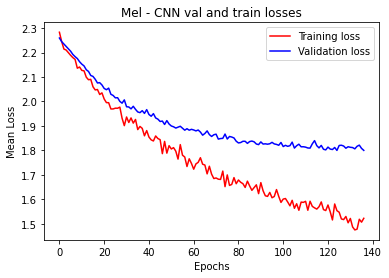

In [123]:
# Plot the loss diagram
title = 'Mel - CNN val and train losses'
plot_losses(train_losses_first_model, val_losses_first_model, title)

In [124]:
# Evaluate the model
predictions_first, labels_first = evaluate(fmodel, test_loader_beat_mel, device = device)

y_true_first = np.concatenate(labels_first, axis=0)
y_pred_first = np.concatenate(predictions_first, axis=0)

print(classification_report(y_true_first, y_pred_first))

              precision    recall  f1-score   support

           0       0.09      0.03      0.04        40
           1       0.48      0.60      0.53        40
           2       0.26      0.34      0.29        80
           3       0.41      0.54      0.47        80
           4       0.33      0.40      0.36        40
           5       0.20      0.07      0.11        40
           6       0.45      0.64      0.53        78
           7       0.00      0.00      0.00        40
           8       0.29      0.32      0.31       103
           9       0.29      0.15      0.20        34

    accuracy                           0.35       575
   macro avg       0.28      0.31      0.28       575
weighted avg       0.30      0.35      0.32       575



In [125]:
# Delete the old dataloaders and dataset, to proceed to regression
del train_loader_beat_mel
del val_loader_beat_mel
del test_loader_beat_mel
del beat_mel_data
del beat_mel_data_test
gc.collect()

3723

In [126]:
os.rename('CNN.pt', 'init-CNN.pt')

In [ ]:
batch_size = 32
val_size = 0.28
test_size = 0.12

beat_mel_data = RegressionSpectrogramDataset(
    os.path.join(DATA_DIR, 'multitask_dataset_beat/'), 
    max_length=maxlength, 
    spectype='mel', 
    regtype='V'
)
train_beat_mel, val_beat_mel, test_beat_mel = torch_train_val_test_split(beat_mel_data, batch_size ,batch_size, val_size = val_size, test_size = test_size)

# We currently have the best trained CNN model on the FMA dataset.
model2 = CNNBackbone(input_features = input_features, input_timesteps = input_timesteps,
                    conv_channels = conv_channels, kernels = kernels, maxpools = maxpools,
                    lin_channels = lin_channels, dropout = dropout, batchnorm=False)
model2.double()
load_backbone_from_checkpoint(model2, './init-CNN.pt')

In [128]:
# We want to cut off the final 2 linear layers and replace them with new ones, so that the network can learn
# them on the new dataset.
model2.fcNo2 = nn.Linear(128,64)
model2.fcNo3 = nn.Linear(64,1)

In [129]:
learning_rate = 0.00001
weight_decay = 1e-6
patience = 15

model2.double()
model2.to(device)
loss_function = nn.MSELoss().to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr = learning_rate, weight_decay = weight_decay)

Initiating training.
[0/2500] Training loss: 0.2267	 Validation loss: 0.0893.
Validation loss increase spotted. Early stopping counter: 1 out of 15
Validation loss increase spotted. Early stopping counter: 1 out of 15
Validation loss increase spotted. Early stopping counter: 2 out of 15
Validation loss increase spotted. Early stopping counter: 3 out of 15
[10/2500] Training loss: 0.0981	 Validation loss: 0.0709.
Validation loss increase spotted. Early stopping counter: 1 out of 15
Validation loss increase spotted. Early stopping counter: 1 out of 15
Validation loss increase spotted. Early stopping counter: 1 out of 15
Validation loss increase spotted. Early stopping counter: 2 out of 15
Validation loss increase spotted. Early stopping counter: 3 out of 15
[20/2500] Training loss: 0.0791	 Validation loss: 0.0662.
Validation loss increase spotted. Early stopping counter: 1 out of 15
Validation loss increase spotted. Early stopping counter: 2 out of 15
Validation loss increase spotted. Ea

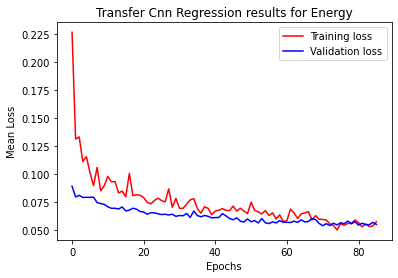

In [130]:
# Train the model
tranfer_train_losses, tranfer_val_losses = train(model2, train_beat_mel, val_beat_mel, optimizer2, epochs, device=device, overfit_batch=overfit_batch, patience=patience, temp = 10)

title = "Transfer Cnn Regression results for Energy"

# Plot the loss diagram
plot_losses(tranfer_train_losses, tranfer_val_losses, title)

In [ ]:
# Evaluate the model
predictions, labels = regression_evaluation(model2, test_beat_mel, device=device)

y_true = np.concatenate(labels, axis=0)
y_pred = np.concatenate(predictions, axis=0)

typemod = 'CNN' 
typefeat = 'Valence'
plot_reg_results(y_true,y_pred,typemod, typefeat)

result = spearmanr(y_true, y_pred)
print(f"The Spearman's rank correlation measure is equal to {100*result[0]:.2f} with p-value = {result[1]:.4f}.")

In [98]:
##Multitask learning
#The __init__() method of this class is responsible for setting up the layers of the network. 
#It starts by calling the super().__init__() method to inherit the functionality of the parent class. Then it initiates some variables and dropout layer.
#It then creates a sequential container which will hold all the convolutional layers, ReLU activations, batchnorms and maxpooling layers 
#in the specified order. The container is called fitter.
#Then, it creates three linear layers for each target, that is valence, energy and dance and these linear layers are grouped as 
#valence_fcNo1, valence_fcNo2 and valence_fcNo3 and so on.
#Finally, the forward() method is responsible for performing the forward pass of the data through the layers of the network. 
#It takes in input tensor, transpose the dimensions and unsqueezes it. 
#Then, it applies the convolutional layers followed by linear layers and outputs the final predictions.
#The network is designed to handle 2D audio data and output three different predictions, one each for valence, energy and dance.

class CNNBackbone(nn.Module):
    def __init__(self, input_features, input_timesteps, conv_channels, kernels, maxpools, lin_channels, dropout, batchnorm):
        super(CNNBackbone, self).__init__()
        self.num_conv_layers = len(kernels)
        self.batchnorm = batchnorm
        self.dropout = nn.Dropout(dropout)
        
        seq = []
        for i in range(self.num_conv_layers):
            seq.append(nn.Conv2d(in_channels=conv_channels[i], 
                                 out_channels=conv_channels[i+1],
                                 kernel_size=kernels[i], stride=1, padding=1))
            seq.append(nn.ReLU())
            if self.batchnorm:
                seq.append(nn.BatchNorm2d(num_features=conv_channels[i+1],track_running_stats=False))
            seq.append(nn.MaxPool2d(kernel_size=maxpools[i]))
            
        # Flatten the output of the final convolution layer
        seq.append(nn.Flatten())
        
        self.fitter = nn.Sequential(*seq)
        
        # Calculation of first linear layer dimensions
        # We build an empty tensor of appropriate size and let him go through
        # the above sequence, in order to calculate the output's size automatically
        first_lin = self.fitter(torch.empty(1,conv_channels[0],input_timesteps,input_features)).size(-1)
        
        self.valence_fcNo1 = nn.Linear(first_lin, lin_channels[0])
        self.valence_fcNo2 = nn.Linear(lin_channels[0], lin_channels[1])
        self.valence_fcNo3 = nn.Linear(lin_channels[1], lin_channels[2])
        
        self.energy_fcNo1 = nn.Linear(first_lin, lin_channels[0])
        self.energy_fcNo2 = nn.Linear(lin_channels[0], lin_channels[1])
        self.energy_fcNo3 = nn.Linear(lin_channels[1], lin_channels[2])
        
        self.dance_fcNo1 = nn.Linear(first_lin, lin_channels[0])
        self.dance_fcNo2 = nn.Linear(lin_channels[0], lin_channels[1])
        self.dance_fcNo3 = nn.Linear(lin_channels[1], lin_channels[2])

    def forward(self, x):
        x = x.transpose(1,2)
        x.unsqueeze_(1)
        out_conv = self.fitter(x)
        
        # Valence Layers
        valence_fc1 = self.valence_fcNo1(out_conv)
        valence_fc1 = nn.ReLU()(valence_fc1)
        valence_fc1 = self.dropout(valence_fc1)
        
        valence_fc2 = self.valence_fcNo2(valence_fc1)
        valence_fc2 = nn.ReLU()(valence_fc2)
        valence_fc2 = self.dropout(valence_fc2)
        
        out_val = self.valence_fcNo3(valence_fc2)
        
        # Energy Layers
        energy_fc1 = self.energy_fcNo1(out_conv)
        energy_fc1 = nn.ReLU()(energy_fc1)
        energy_fc1 = self.dropout(energy_fc1)
        
        energy_fc2 = self.energy_fcNo2(energy_fc1)
        energy_fc2 = nn.ReLU()(energy_fc2)
        energy_fc2 = self.dropout(energy_fc2)
        
        out_en = self.energy_fcNo3(energy_fc2)
        
        # Danceability Layers
        dance_fc1 = self.dance_fcNo1(out_conv)
        dance_fc1 = nn.ReLU()(dance_fc1)
        dance_fc1 = self.dropout(dance_fc1)
        
        dance_fc2 = self.dance_fcNo2(dance_fc1)
        dance_fc2 = nn.ReLU()(dance_fc2)
        dance_fc2 = self.dropout(dance_fc2)
        
        out_dance = self.dance_fcNo3(dance_fc2)
        
        out_list = list((out_val, out_en, out_dance))
        
        # Returns output for all three tasks
        return out_list

In [99]:
#The __init__ method of the class is called when the MultiTaskLoss object is created. It accepts one argument called 'weights' 
#which is a list of weightings for each of the three tasks.
#The forward method is called when the loss is calculated during training. 
#This method takes in two arguments: predictions and targets. predictions is a list of the predicted values for 
#valence, energy, and danceability (in that order), and targets is a list of the target values for valence, energy, and danceability (in that order).
#The forward method starts by defining the loss function for single task, in this case it is 'nn.MSELoss' which calculates the mean squared error 
#of the predictions and the targets.
#Then, it calculates the loss for each task by calling the single loss function on the appropriate predictions and targets, 
#storing them as loss_val, loss_en, and loss_dance respectively.
#Finally, it calculate total loss as the weighted sum of loss for all three tasks, where the weighting factors are specified in the weights list 
#passed in the constructor.
#This loss function allows you to assign different weightings to each task, so that the model can place more importance on certain tasks if desired.

class MultiTaskLoss(nn.Module):
    def __init__(self, weights):

        super(MultiTaskLoss, self).__init__()
        self.weights = weights

    def forward(self, predictions, targets):

        single_loss = nn.MSELoss()

        loss_val = single_loss(predictions[0], targets[0])
        loss_en = single_loss(predictions[1], targets[1])
        loss_dance = single_loss(predictions[2], targets[2])
        
        total_loss = self.weights[0]*loss_val + self.weights[1]*loss_en + self.weights[2]*loss_dance
        
        return total_loss

In [100]:
#returns the lists of predictions and labels for each task.
#This function can be used to evaluate the performance of a multi-task model on a given test dataset
#by comparing the predicted values and the true labels for each task.

def evaluate_multitask(model, test_dataloader, device="cuda"):
    model.eval()
    predictions_val = []
    labels_val = []
    predictions_en = []
    labels_en = []
    predictions_dance = []
    labels_dance = []
    
    with torch.no_grad():
        for batch in test_dataloader:
            
            x_batch, y_batch, x_len = batch
                
            # Move to device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            if isinstance(model, LSTMBackbone):
                yhat = model(x_batch, x_len)
            elif isinstance(model, CNNBackbone):
                yhat = model(x_batch) # No unpacking occurs in CNNs
                
            predictions_val.append(torch.flatten(yhat[0]).cpu().numpy())
            predictions_en.append(torch.flatten(yhat[1]).cpu().numpy())
            predictions_dance.append(torch.flatten(yhat[2]).cpu().numpy())
            
            labels_val.append(y_batch[:,0].cpu().numpy())
            labels_en.append(y_batch[:,1].cpu().numpy())
            labels_dance.append(y_batch[:,2].cpu().numpy())
    
    return predictions_val, predictions_en, predictions_dance, labels_val, labels_en, labels_dance      

In [ ]:
batch_size = 32
val_size = 0.28
test_size = 0.12

beat_mel_data = RegressionSpectrogramDataset(
    os.path.join(DATA_DIR, 'multitask_dataset_beat/'), 
    spectype='mel', 
    regtype='ALL'
)
train_beat_mel, val_beat_mel, test_beat_mel = torch_train_val_test_split(beat_mel_data, batch_size, batch_size, val_size = val_size, test_size = test_size)


In [115]:
input_features = beat_mel_data[0][0].shape[1] 
input_timesteps = beat_mel_data[0][0].shape[0] 
conv_channels = [1,4,16,64,256]
kernels = [3,3,3,3]
maxpools = [2,2,2,2]
lin_channels = [128,64,1]
dropout = 0.2
learning_rate = 0.00005
weight_decay = 1e-6
patience = 12
overfit_batch = False
temp = 10

epochs = 2500

model = CNNBackbone(input_features = input_features, input_timesteps = input_timesteps,
                    conv_channels = conv_channels, kernels = kernels, maxpools = maxpools,
                    lin_channels = lin_channels, dropout = dropout, batchnorm=False)
model.double()
model.to(device)

weights = [5/10,1/10,4/10]

loss_function = MultiTaskLoss(weights = weights)

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

# Train the model
multitask_train_losses, multitask_val_losses = train(model, train_beat_mel, val_beat_mel, optimizer, epochs, device=device, overfit_batch=overfit_batch, patience=patience, temp=temp)

Initiating training.
[0/2500] Training loss: 0.1497	 Validation loss: 0.0773.
Validation loss increase spotted. Early stopping counter: 1 out of 12
Validation loss increase spotted. Early stopping counter: 1 out of 12
Validation loss increase spotted. Early stopping counter: 2 out of 12
Validation loss increase spotted. Early stopping counter: 3 out of 12
[10/2500] Training loss: 0.0878	 Validation loss: 0.0715.
Validation loss increase spotted. Early stopping counter: 1 out of 12
Validation loss increase spotted. Early stopping counter: 1 out of 12
Validation loss increase spotted. Early stopping counter: 1 out of 12
Validation loss increase spotted. Early stopping counter: 1 out of 12
[20/2500] Training loss: 0.0712	 Validation loss: 0.0647.
Validation loss increase spotted. Early stopping counter: 1 out of 12
Validation loss increase spotted. Early stopping counter: 1 out of 12
Validation loss increase spotted. Early stopping counter: 2 out of 12
Validation loss increase spotted. Ea

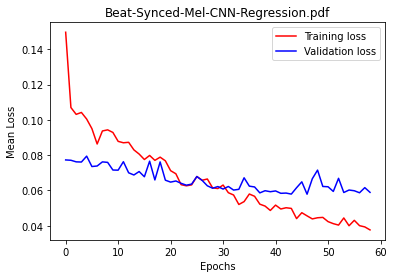

In [116]:
typemod = 'CNN'
title = f"Beat-Synced-Mel-{typemod}-Regression.pdf"

# Plot the loss diagram
plot_losses(multitask_train_losses, multitask_val_losses, title)

# Evaluate the model
pred_val, pred_en, pred_dance, lab_val, lab_en, lab_dance = evaluate_multitask(model, test_beat_mel, device=device)

y_val_true = np.concatenate(lab_val, axis=0)
y_val_pred = np.concatenate(pred_val, axis=0)


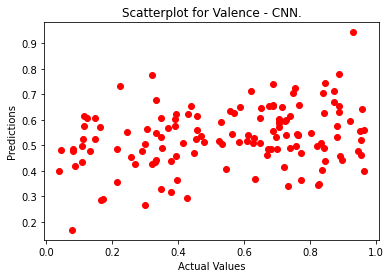

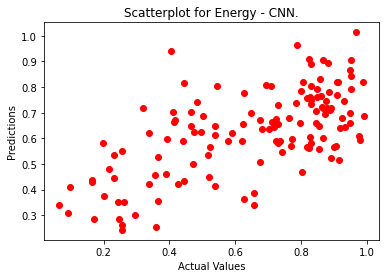

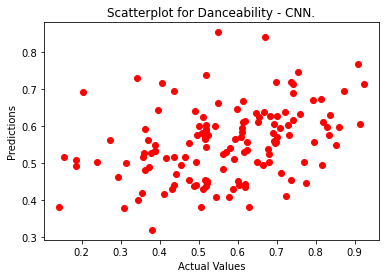

Spearman's rank correlation measure is equal to:
Valence: 24.03%, with p-value = 0.0052.
Energy: 59.63%, with p-value = 0.0000.
Danceability: 38.31%, with p-value = 0.0000.
Total: 40.66%.


In [117]:
typefeat = 'Valence'
plot_reg_results(y_val_true,y_val_pred,typemod,typefeat)

result_val = spearmanr(y_val_true, y_val_pred)

y_en_true = np.concatenate(lab_en, axis=0)
y_en_pred = np.concatenate(pred_en, axis=0)

typefeat = 'Energy'
plot_reg_results(y_en_true,y_en_pred,typemod,typefeat)

result_en = spearmanr(y_en_true, y_en_pred)

y_dance_true = np.concatenate(lab_dance, axis=0)
y_dance_pred = np.concatenate(pred_dance, axis=0)

typefeat = 'Danceability'
plot_reg_results(y_dance_true,y_dance_pred,typemod,typefeat)

result_dance = spearmanr(y_dance_true, y_dance_pred)

print("Spearman's rank correlation measure is equal to:")
print(f"Valence: {100*result_val[0]:.2f}%, with p-value = {result_val[1]:.4f}.")
print(f"Energy: {100*result_en[0]:.2f}%, with p-value = {result_en[1]:.4f}.")
print(f"Danceability: {100*result_dance[0]:.2f}%, with p-value = {result_dance[1]:.4f}.")
totspear = (1/3)*(result_val[0] + result_en[0] + result_dance[0])
print(f"Total: {100*totspear:.2f}%.")